### polybert fingerprints

In [1]:
!pip install rdkit

In [1]:
import pandas as pd
df_combined = pd.read_csv('sigma_data.csv')


In [3]:
s_Df = df_combined[df_combined['synthetic'] == False]
s_Df

,Plastic Type,Enzyme Name,protein_sequence,smiles,protein_length,synthetic,cluster,Cluster


In [4]:
df_combined

,Plastic Type,Enzyme Name,protein_sequence,smiles,protein_length,synthetic,cluster,Cluster
0,PCL,Cutinase,MKFFALTTLLAATASALPTSHPVQELEARQLGGGTTRNDLTNGNSA...,[*]OCCCCC(=O)[*],231,NaN,13.0,7
1,PCL,Cutinase,MKFFALTTLLAATASALPTSAPVAELEARQLGAGTTRNDLTNGNSA...,[*]OCCCCC(=O)[*],231,True,13.0,7
2,PCL,Cutinase,MKFFALTTLLAATASALPTSIPVQELEARQLGGGTTRNDLTNGNSA...,[*]OCCCCC(=O)[*],231,True,13.0,7
3,PCL,Cutinase,MKFFAITTLLAATASALPTSHPVQELEARQLGGGTTRNDLTNGNSA...,[*]OCCCCC(=O)[*],231,True,13.0,7
4,PCL,Cutinase,MKFFALTTLLAATAAALPTSAPVVELEARQLGGGTTRNDLTNGNSA...,[*]OCCCCC(=O)[*],231,True,13.0,7
...,...,...,...,...,...,...,...,...
9022,PE,Manganese_Peroxidase_Iz-MnP2,MRLIGSSLLSASLRLARQAPAAELAACPDGTRVSNSACCAFIPIAQ...,[*]CC[*],385,True,14.0,10
9023,PE,Manganese_Peroxidase_Iz-MnP2,MALHLSSLLSASLRLLVAAPAAETAVCPDGTRTSNSACCAFLPLAQ...,[*]CC[*],385,True,14.0,10
9024,PE,Manganese_Peroxidase_Iz-MnP2,MALLLSSLLSASPILSRAAPAARSAVCPDGQRVANPACCAFFPIAQ...,[*]CC[*],385,True,14.0,10
9025,PE,Manganese_Peroxidase_Iz-MnP2,MALHLSLLLSALARLVRTLSAANTAVCPDGTRVSNSACCAFFPVAQ...,[*]CC[*],385,True,14.0,10


In [11]:
smiles_list = []
unique_smiles = set(df_combined['smiles'].unique())

for smiles in unique_smiles:
    # Remove any existing '[*]' at the start and end, even if there are spaces
    stripped_smiles = smiles.strip().lstrip("[*]").rstrip("[*]").strip()

    # Wrap properly
    formatted_smiles = f"[*]{stripped_smiles}[*]"
    smiles_list.append(formatted_smiles)

smiles_list


['[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCC(=O)[*]',
 '[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCC(=O)[*].[*]OCCOC(=O)CC(=O)O[*].[*]OC(C)C(=O)[*].[*]OC(C)CC(=O)[*]',
 '[*]NCCCCNCCCC(=O)O[*]',
 '[*]CCO[*]',
 '[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*].[*]OC(C)C(=O)[*]',
 '[*]OCCO[*]',
 '[*]OCCCCC(=O)[*]',
 '[*]OCCOC(=O)CC(=O)O[*].[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*]',
 '[*]OC(C)C(=O)[*].[*]OC(C)CC(=O)[*].[*]OCCOC(=O)CC(=O)O[*].[*]OCCCCC(=O)[*]',
 '[*]OC(C)C(=O)[*].[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCC(=O)[*].[*]OCCOC(=O)CC(=O)O[*].[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*]',
 '[*]OC(C)C(=O)[*].[*]OCCCCC(=O)[*].[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCOC(=O)CC(=O)O[*].[*]OC(C)CC(=O)[*]',
 '[*]OCCCCOC(=O)CC(=O)O[*]',
 '[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCOC(=O)CC(=O)O[*].[*]OCCCCC(=O)[*]',
 '[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCC(=O)[*].[*]OCCOC(=O)CC(=O)O[*].[*]OC(C)CC(=O)[*].[*]OC(C)C(=O)[*].[*]OC(C)CC(=O)[*]',
 '[*]OCCCCOC(=O)CC(=O)O[*].[*]OCC

In [12]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

class PolyBERTEncoder(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.polybert = AutoModel.from_pretrained('kuelumbus/polyBERT')
        self.tokenizer = AutoTokenizer.from_pretrained('kuelumbus/polyBERT')
        self.output_dim = output_dim
        self.projection = nn.Linear(self.polybert.config.hidden_size, output_dim)

    def forward(self, smiles_strings):
        # Tokenize
        encoded_input = self.tokenizer(smiles_strings,
                                       padding=True,
                                       truncation=True,
                                       return_tensors='pt').to(next(self.polybert.parameters()).device)

        # Raw PolyBERT output
        with torch.no_grad():
            model_output = self.polybert(**encoded_input)
        sequence_embeddings = model_output.last_hidden_state  # [batch, seq_len, hidden_size]
        print("Raw Sequence Embeddings Shape:", sequence_embeddings.shape)
        print("Raw Sequence Embeddings Sample:", sequence_embeddings[0, :5, :5])  # First 5 tokens, 5 dims

        # Mean pooling over sequence length
        raw_embeddings = sequence_embeddings.mean(dim=1)  # [batch, hidden_size]
        print("Raw Pooled Embeddings Shape:", raw_embeddings.shape)
        print("Raw Pooled Cos Sim:", cosine_similarity(raw_embeddings.cpu().numpy()).mean())
        print("Raw Pooled Sample:", raw_embeddings[:5, :5])

        # Projection
        projected_output = self.projection(sequence_embeddings)  # [batch, seq_len, output_dim]
        print("Projected Embeddings Shape:", projected_output.shape)
        projected_pooled = projected_output.mean(dim=1)  # [batch, output_dim]
        print("Projected Pooled Cos Sim:", cosine_similarity(projected_pooled.cpu().detach().numpy()).mean())
        print("Projected Pooled Sample:", projected_pooled[:5, :5])

        return projected_output  # Still returns [batch, seq_len, output_dim]

# Test with your SMILES list
smiles_list = list(df_combined['smiles'].unique())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
polybert_encoder = PolyBERTEncoder(output_dim=256).to(device)
raw_projected_embeddings = polybert_encoder(smiles_list)

# Normalize and check
normalized_embeddings = raw_projected_embeddings.mean(dim=1)  # Pool to [batch, 256]
normalized_embeddings = normalized_embeddings / normalized_embeddings.norm(dim=-1, keepdim=True).clamp(min=1e-7)
print("Normalized Embeddings Shape:", normalized_embeddings.shape)
print("Normalized Cos Sim:", cosine_similarity(normalized_embeddings.cpu().detach().numpy()).mean())
print("Normalized Sample:", normalized_embeddings[:5, :5])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Raw Sequence Embeddings Shape: torch.Size([30, 126, 600])
Raw Sequence Embeddings Sample: tensor([[-0.0092,  0.2755, -0.4806, -1.4089, -2.2509],
        [-0.0430,  0.4276, -0.5884, -1.4104, -2.2687],
        [ 0.0815,  0.0174,  0.4578, -0.9439, -1.9573],
        [ 0.7367, -0.3353, -0.0622, -0.3803, -1.8088],
        [ 0.5147,  0.4097,  0.1846, -2.0083, -1.0798]], device='cuda:0')
Raw Pooled Embeddings Shape: torch.Size([30, 600])
Raw Pooled Cos Sim: 0.8083693
Raw Pooled Sample: tensor([[ 1.2551,  1.3380, -0.4130,  0.4943, -1.3191],
        [ 1.1604,  1.5419, -0.5716,  0.1570, -0.9123],
        [ 1.0575,  0.8955, -0.0894,  1.2649, -0.8457],
        [ 1.3844,  1.4011, -0.4012,  0.4703, -1.4604],
        [ 1.1788,  1.4684, -0.5570,  0.2999, -0.8306]], device='cuda:0')
Projected Embeddings Shape: torch.Size([30, 126, 256])
Projected Pooled Cos Sim: 0.79702175
Projected Pooled Sample: tensor([[-0.1068,  0.4629, -1.1883, -0.3747, -0.4732],
        [-0.3430,  0.4556, -1.1637, -0.3639, -0.6661

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# Pick diverse SMILES
test_smiles = [
    "[*]CCO[*]",
    "[*]NCCCCNCCCC(=O)O[*]",
    "[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*]",
    "[*]OC(C)C(=O)[*]"
]
polybert_encoder = PolyBERTEncoder(output_dim=256).to(device)
raw_projected = polybert_encoder(test_smiles)
pooled_embeddings = raw_projected.mean(dim=1)
cos_sim_matrix = cosine_similarity(pooled_embeddings.cpu().detach().numpy())
print("Pairwise Cos Sim Matrix:\n", cos_sim_matrix)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Raw Sequence Embeddings Shape: torch.Size([4, 30, 600])
Raw Sequence Embeddings Sample: tensor([[ 0.2641,  0.4064, -0.9320, -1.0198, -1.7431],
        [ 0.2463,  0.4902, -0.9593, -1.0126, -1.6991],
        [ 0.5188,  0.1787,  0.1840, -0.7893, -1.7386],
        [ 0.9525,  0.4810,  0.6171, -0.9781, -1.4589],
        [ 1.1858,  0.6167, -0.4118, -0.9430, -1.9459]], device='cuda:0')
Raw Pooled Embeddings Shape: torch.Size([4, 600])
Raw Pooled Cos Sim: 0.7310372
Raw Pooled Sample: tensor([[ 1.2448,  1.3446, -0.5050,  0.2491, -1.6926],
        [ 0.9182,  0.7017,  0.6000, -0.4046, -0.5265],
        [ 0.8717,  0.0715,  0.9499,  0.4704, -1.1281],
        [ 0.8698,  0.8205,  0.1322, -0.8960, -1.7721]], device='cuda:0')
Projected Embeddings Shape: torch.Size([4, 30, 256])
Projected Pooled Cos Sim: 0.6988541
Projected Pooled Sample: tensor([[ 0.7583,  0.2264,  0.1378,  0.0696, -0.3924],
        [ 0.4842,  0.4137, -0.0345,  0.6175, -0.4094],
        [ 0.1576, -0.0158, -0.1312, -0.0887, -0.1899],
   

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Pairwise Cosine Similarity Matrix:
 [[0.9999999  0.7753461  0.8893608  0.8860746  0.8429448  0.94228286
  0.35395128 0.46348843 0.45312524 0.3810813 ]
 [0.7753461  0.9999998  0.8816548  0.80848855 0.87644416 0.87584466
  0.5422297  0.6171322  0.74383485 0.5617026 ]
 [0.8893608  0.8816548  1.0000001  0.8567298  0.82729024 0.87884575
  0.5400808  0.6653832  0.6806501  0.5872549 ]
 [0.8860746  0.80848855 0.8567298  1.         0.76514184 0.83787435
  0.5019182  0.5606267  0.5984615  0.5292397 ]
 [0.8429448  0.87644416 0.82729024 0.76514184 0.99999994 0.94439363
  0.40272665 0.44330746 0.5133944  0.394264  ]
 [0.94228286 0.87584466 0.87884575 0.83787435 0.94439363 0.9999997
  0.358656   0.44335613 0.48699635 0.364854  ]
 [0.35395128 0.5422297  0.5400808  0.5019182  0.40272665 0.358656
  1.0000001  0.8691161  0.81571615 0.93919456]
 [0.46348843 0.6171322  0.6653832  0.5606267  0.44330746 0.44335613
  0.8691161  1.         0.86274904 0.928212  ]
 [0.45312524 0.74383485 0.6806501  0.5984615  0

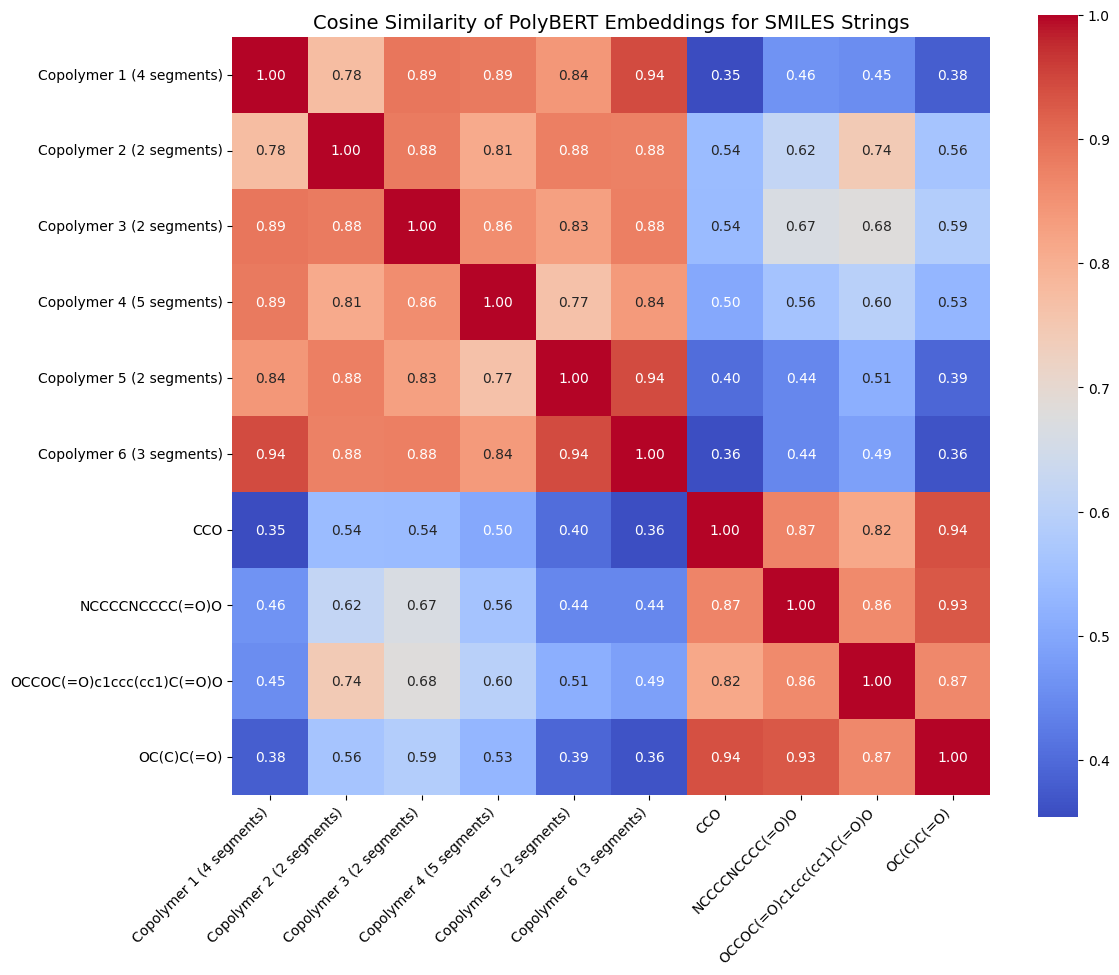

In [15]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class PolyBERTEncoder(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.polybert = AutoModel.from_pretrained('kuelumbus/polyBERT')
        self.tokenizer = AutoTokenizer.from_pretrained('kuelumbus/polyBERT')
        self.output_dim = output_dim
        self.projection = nn.Linear(self.polybert.config.hidden_size, output_dim)

    def forward(self, smiles_strings):
        encoded_input = self.tokenizer(smiles_strings,
                                       padding=True,
                                       truncation=True,
                                       return_tensors='pt').to(next(self.polybert.parameters()).device)
        with torch.no_grad():
            model_output = self.polybert(**encoded_input)
        sequence_embeddings = model_output.last_hidden_state
        projected_output = self.projection(sequence_embeddings)
        return projected_output

# SMILES list
smiles_list = [
    '[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCC(=O)[*].[*]OCCOC(=O)CC(=O)O[*]',
    '[*]OCCCCC(=O)[*].[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*]',
    '[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCOC(=O)CC(=O)O[*]',
    '[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCC(=O)[*].[*]OC(C)CC(=O)[*].[*]OC(C)C(=O)[*].[*]OC(C)CC(=O)[*]',
    '[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*].[*]OCCOC(=O)c1ccoc1C(=O)O[*]',
    '[*]OCCOC(=O)CC(=O)O[*].[*]OCCCCC(=O)[*].[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*]',
    '[*]CCO[*]',
    '[*]NCCCCNCCCC(=O)O[*]',
    '[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*]',
    '[*]OC(C)C(=O)[*]'
]

# Short labels for plotting
labels = [
    'Copolymer 1 (4 segments)',
    'Copolymer 2 (2 segments)',
    'Copolymer 3 (2 segments)',
    'Copolymer 4 (5 segments)',
    'Copolymer 5 (2 segments)',
    'Copolymer 6 (3 segments)',
    'CCO',
    'NCCCCNCCCC(=O)O',
    'OCCOC(=O)c1ccc(cc1)C(=O)O',
    'OC(C)C(=O)'
]

# Compute embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
polybert_encoder = PolyBERTEncoder(output_dim=256).to(device)
raw_projected = polybert_encoder(smiles_list)
pooled_embeddings = raw_projected.mean(dim=1)  # [10, 256]
cos_sim_matrix = cosine_similarity(pooled_embeddings.cpu().detach().numpy())

# Print matrix
print("Pairwise Cosine Similarity Matrix:\n", cos_sim_matrix)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cos_sim_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            xticklabels=labels, yticklabels=labels, square=True)
plt.title('Cosine Similarity of PolyBERT Embeddings for SMILES Strings', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [4]:
unique_df = df_combined.drop_duplicates(subset=['smiles'])
unique_df = unique_df.reset_index(drop=True)
unique_df


,Plastic Type,Enzyme Name,protein_sequence,smiles,protein_length,synthetic,cluster,Cluster
0,PCL,Cutinase,MKFFALTTLLAATASALPTSHPVQELEARQLGGGTTRNDLTNGNSA...,[*]OCCCCC(=O)[*],231,NaN,13.0,7
1,PVA,PVA_dehydrogenase,MQQNIERNQVSMTTSRFVWGAVMALVALGSASAAELNLPDGAALYR...,CCO,639,NaN,2.0,5
2,P3HP_P4HB_PEA_PES_PHB_PHA,PHB_depolymerase,MTKQSLPQGMADQRLCRFFTAALCSLLMLLLWPTTVTAGQTFSYTS...,[*]OCCOC(=O)CC(=O)O[*].[*]OC(C)CC(=O)[*].[*]OC...,576,NaN,6.0,12
3,PLA,PLA_depolymerase,MRKLKLLLMVCMSMVFIFTLPGMGQSLKASAATERTPIVFVHGLTG...,[*]OC(C)C(=O)[*],201,NaN,8.0,4
4,PEG,PEG_dehydrogenase,MCLVTLYRCTPIWVRNRGMHKFDFVVVGAGSAGCTVASRLSENGKY...,OCCO,553,NaN,18.0,15
5,PCL_PHA_PHBV_PHPV,MCL_PHA_depolymerase,MLAPRSLLFCLLLFALPNAFADSRCSERAKTLLLPAKVSCSYKTTW...,[*]OCCCCC(=O)[*].[*]OC(C)CC(=O)[*],277,NaN,15.0,17
6,Nylon,Nylon_Oligomer_Degrading_Enzyme,MLRFDFPGVSIGAAHYEEGPTGATVIHIPAGARTAVDARGGAVGLS...,NCCCCNCCCC(=O)O,306,NaN,5.0,3
7,PBAT_PBS_PBSA_PCL_PET_PHB_PLA_PHA,Cutinase,MRIRRQAGTGARASMARAIGVMTTALAVLVGAVGGVAGAEVSTAQD...,[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCOC(=O)CC(=O)O...,304,NaN,12.0,16
8,PCL_PET,Cutinase,MLPAGQDAAALEARQLGGSITRNDLANGNSGSCPGVIFIYARGSTE...,[*]OCCCCC(=O)[*].[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*],226,NaN,1.0,8
9,PBS_PBSA_PCL,Esterase,MQFKSTFAALVLAAAGLVQAAPLQERAGCSSYVIINTRGTSEPQGP...,[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCOC(=O)CC(=O)O...,224,NaN,3.0,21


In [5]:
unique_df.to_csv('unique_df.csv')

In [6]:
from transformers import AutoTokenizer, AutoModel
import torch


In [7]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from transformers import AutoModel, AutoTokenizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

# Load dataset
df_combined = pd.read_csv('sigma_data.csv')
df_combined = df_combined.drop(columns=[col for col in ['cluster', 'Cluster'] if col in df_combined.columns], errors='ignore')

# Ensure SMILES have [*] markers
def format_smiles(smiles):
    if not smiles.startswith('[*]'):
        smiles = '[*]' + smiles
    if not smiles.endswith('[*]'):
        smiles = smiles + '[*]'
    return smiles

df_combined['smiles'] = df_combined['smiles'].apply(format_smiles)

class PolyBERTEncoder(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.polybert = AutoModel.from_pretrained('kuelumbus/polyBERT')
        self.tokenizer = AutoTokenizer.from_pretrained('kuelumbus/polyBERT')
        self.output_dim = output_dim
        # Project each token embedding to required dimension
        self.projection = nn.Linear(self.polybert.config.hidden_size, output_dim)

    def forward(self, smiles_strings):
        # Tokenize the SMILES strings
        encoded_input = self.tokenizer(smiles_strings,
                                     padding=True,
                                     truncation=True,
                                     return_tensors='pt').to(next(self.polybert.parameters()).device)

        # Get PolyBERT embeddings
        with torch.no_grad():
            model_output = self.polybert(**encoded_input)

        # Debug prints
        # print("Model Output Keys:", model_output.keys())
        # print("Last Hidden State Shape:", model_output.last_hidden_state.shape)  # [batch_size, seq_len, hidden_size]

        # Get sequence embeddings
        sequence_embeddings = model_output.last_hidden_state

        # Project each token embedding to required dimension
        projected_output = self.projection(sequence_embeddings)  # [batch_size, seq_len, output_dim]
        # print("Projected Output Shape:", projected_output.shape)
        # Take the mean over the sequence length dimension
        pooled_output = projected_output.mean(dim=1)  # [batch_size, output_dim]

        return pooled_output

# Initialize PolyBERT Encoder
encoder = PolyBERTEncoder(output_dim=256).eval().to('cuda' if torch.cuda.is_available() else 'cpu')

# Encode SMILES strings
fingerprints = []
valid_indices = []

for i, smiles in enumerate(df_combined['smiles']):
    try:
        fp = encoder([smiles])  # [1, output_dim] after mean pooling
        fingerprints.append(fp.detach().cpu().numpy().flatten())  # Ensure it's 1D
        valid_indices.append(i)
    except Exception as e:
        print(f"Error processing SMILES {smiles}: {e}")

X = np.vstack(fingerprints)
n_clusters = 12

# Apply KMeans Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=15)
cluster_labels = kmeans.fit_predict(X)

df_valid = df_combined.iloc[valid_indices].copy()
df_valid['cluster'] = cluster_labels

# Subset selection
def subset_clusters(df, subset_fraction=0.5):
    return df.groupby('cluster', group_keys=False).apply(lambda x: x.sample(frac=subset_fraction, random_state=42))

df_subset = subset_clusters(df_valid, subset_fraction=0.5)
cluster_centers = kmeans.cluster_centers_

# Splitting by cluster dissimilarity
def split_by_cluster_dissimilarity(df, cluster_centers, val_size=0.3):
    unique_clusters = df['cluster'].unique()
    n_clusters = len(unique_clusters)
    n_val = int(n_clusters * val_size)
    distances = euclidean_distances(cluster_centers)
    np.random.seed(42)
    current_cluster = np.random.choice(unique_clusters)
    val_clusters = [current_cluster]
    remaining_clusters = set(unique_clusters) - {current_cluster}

    while len(val_clusters) < n_val:
        avg_distances = [(cluster, np.mean([distances[cluster, val_cluster] for val_cluster in val_clusters])) for cluster in remaining_clusters]
        next_cluster = max(avg_distances, key=lambda x: x[1])[0]
        val_clusters.append(next_cluster)
        remaining_clusters.remove(next_cluster)

    train_clusters = list(set(unique_clusters) - set(val_clusters))
    return df[df['cluster'].isin(train_clusters)], df[df['cluster'].isin(val_clusters)]

train_df, val_df = split_by_cluster_dissimilarity(df_subset, cluster_centers)

print(f"Training set: {len(train_df)} samples, {train_df['cluster'].nunique()} clusters")
print(f"Validation set: {len(val_df)} samples, {val_df['cluster'].nunique()} clusters")

train_df.to_csv('train_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Training set: 4131 samples, 9 clusters
Validation set: 383 samples, 3 clusters


<ipython-input-7-4704e4346094>:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('cluster', group_keys=False).apply(lambda x: x.sample(frac=subset_fraction, random_state=42))


In [8]:
# Move cluster 0 from val_df to train_df
cluster_0_data = val_df[val_df['cluster'] == 0]
val_df = val_df[val_df['cluster'] != 0]  # Remove from val_df

# Move cluster 3 from train_df to val_df
cluster_3_data = train_df[train_df['cluster'] == 3]
train_df = train_df[train_df['cluster'] != 3]  # Remove from train_df

# Swap the clusters
train_df = pd.concat([train_df, cluster_0_data], ignore_index=True)
val_df = pd.concat([val_df, cluster_3_data], ignore_index=True)

# Save the updated datasets
train_df.to_csv('train_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)


In [9]:
print(f"Updated Training set: {len(train_df)} samples, {train_df['cluster'].nunique()} clusters")
print(f"Updated Validation set: {len(val_df)} samples, {val_df['cluster'].nunique()} clusters")

Updated Training set: 3469 samples, 9 clusters
Updated Validation set: 1045 samples, 3 clusters


In [10]:
unique_df = train_df.drop_duplicates(subset=['smiles'])
unique_df = unique_df.reset_index(drop=True)
unique_df


,Plastic Type,Enzyme Name,protein_sequence,smiles,protein_length,synthetic,cluster
0,PET,Lipase,MKLLSLTVVAGVLATLVAATPLVKRAPSGSDPAFSQPKSVLLAGLT...,[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*],342,True,1
1,PLA,Protease,MMRKKSFWLGMLTAFMLVFTMAFSDSASAAQPAKNVEKDYIVGFKS...,[*]OC(C)C(=O)[*],379,NaN,2
2,Nylon,Hydrolase,MNARSTPQHPAADPGAAAGEPTLDDWQRPPHNRWAFAHVGELLPTA...,[*]NCCCCNCCCC(=O)O[*],392,True,4
3,PBSA,Lipase,MNLVGHSQGGLTSRYVAAVAPELVASVTTIGTPHRGSEGADFVQSV...,[*]OCCCCOC(=O)CC(=O)O[*],240,True,4
4,PBS_PBSA_PCL_PES_PHB_PLA_PHA,PLA_depolymerase,MLLKKLTLIFISFLLAIILLIPAAASASEKDYKPGIALEPIKNSEG...,[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCOC(=O)CC(=O)O...,431,True,5
5,P3HP_P4HB_PEA_PES_PHB_PHA,PHB_depolymerase,MTKQSLPQSMAKQRLCRFFTAALLSLLMLLLWPTTAHAGQTFSYTS...,[*]OCCOC(=O)CC(=O)O[*].[*]OC(C)CC(=O)[*].[*]OC...,576,True,5
6,PLA_PBSA,Esterase,MTAIIRQGRVQGLSSDGVTEFRGIPFAAAPLGELRFRAPQPLPDSE...,[*]OC(C)C(=O)[*].[*]OCCCCOC(=O)CC(=O)O[*],505,True,5
7,PBS_PCL_PHB_PLA_PHA,Cutinase,MLQSALALAVLSAASLGLAAPTPESAEAHELEARATSSACPSYVLI...,[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCC(=O)[*].[*]O...,238,True,5
8,PBS_PBSA,Cutinase,MHLRNIVIALAATAVASPVDLQDRQLSTNNELRDGPCKPITFIFAR...,[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCOC(=O)CC(=O)O[*],213,True,5
9,PLA_PBS_PBSA_PCL_PES_PHB_PHA,PLA_depolymerase,MKTKKAVLLAIAALLFLTDLPGNAGASEKQRDLVLVHGLTNKHRWS...,[*]OC(C)C(=O)[*].[*]OCCCCOC(=O)CC(=O)O[*].[*]O...,283,True,5


In [11]:
train_df

,Plastic Type,Enzyme Name,protein_sequence,smiles,protein_length,synthetic,cluster
0,PET,Lipase,MKLLSLTVVAGVLATLVAATPLVKRAPSGSDPAFSQPKSVLLAGLT...,[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*],342,True,1
1,PET,PETase,MLERPVTFRNEGEKIIGILHIPDNIRPGEKVPGILMFHGFTGNKTE...,[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*],272,True,1
2,PET,MHETase,MRHTRRTMLLASVALAACGGGGGTPSPSPQQQPPQQEPPPPPPPLA...,[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*],603,True,1
3,PET,PET6,MNVLTKCKISLGIIAIFFSLPSFAVTCSPCSNGFERGQGPTVDQLT...,[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*],297,True,1
4,PET,MHETase,MKTRLTTMLLASVALAACAGGGDTPLPLPQQPPPQQQPPPPPPPLA...,[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*],603,True,1
...,...,...,...,...,...,...,...
3464,PCL_PET,Cutinase,MHGVLWRLRLAALRAALLALAAVALVVASPSVEAQSNPYQRGPAPT...,[*]OCCCCC(=O)[*].[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*],293,True,0
3465,PCL_PET,PET-hydrolase,MLNVLTFGKLALGIIAIFFALPSFAVPCSDCSNGFERGPDPTVSQL...,[*]OCCCCC(=O)[*].[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*],298,True,0
3466,PCL_PET,PETase,MNKSILLALGFGISVLLVSMNALSVTPSPTPTPDPDPDPTPTQDNC...,[*]OCCCCC(=O)[*].[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*],310,True,0
3467,PET_PEF,PETase,MNFARASRLMSAAVLGALAAVSAAATAQTNPYARGPDPTAASLEAS...,[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*].[*]OCCOC(=O)c1...,290,True,0


In [12]:
unique_df = val_df.drop_duplicates(subset=['smiles'])
unique_df = unique_df.reset_index(drop=True)
unique_df


,Plastic Type,Enzyme Name,protein_sequence,smiles,protein_length,synthetic,cluster
0,PVA,PVA_dehydrogenase,MKANIERNAVSGTASRFVLGAVTALVALGTASAAEQNLPDGAALYR...,[*]CCO[*],639,True,6
1,PEG,PEG_dehydrogenase,MCLVTLYFCTWINVRNRGMPDFDFIVVGAGSAGCVVASRLSETGKY...,[*]OCCO[*],553,True,11
2,PHA_PHB,PHA_depolymerase,MLYQLHEFNRSLLEPFEALAQATAKTFQNPLSPLSLVPGAKRLAAG...,[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*],419,True,3
3,PCL_PHA_PHBV_PHPV,MCL_PHA_depolymerase,MLAPRVLLFCLLLFALPNAFADSRCSERANTLLLPAKPSESAKTTI...,[*]OCCCCC(=O)[*].[*]OC(C)CC(=O)[*],277,True,3


### setup

In [1]:
!pip install Levenshtein
# !pip install einops
# !pip install einops_exts
!pip install torch
!pip install transformers
!pip install tqdm
!pip install sentencepiece
# !pip install fair-esm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import pandas as pd
import re
import math
import json
from tqdm import tqdm
from einops import rearrange, repeat
# import esm

# Set up GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# # Load ESM-2 model
# esm_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
# batch_converter = alphabet.get_batch_converter()
# esm_model = esm_model.to(device)  # Move to GPU if available
# esm_model.eval()  # Set to evaluation mode


Using device: cuda


### data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def preprocess_snp_data(file_path):
    snp_df = pd.read_csv(file_path)

    # Basic preprocessing and length calculations
    snp_df['smiles_length'] = snp_df['smiles'].apply(len)
    snp_df['protein_length'] = snp_df['protein_sequence'].apply(len)

    return snp_df

def filter_datasets(dataset):
    return dataset[
        (dataset['smiles'].notna()) &
        (dataset['protein_sequence'].notna()) &
        (dataset['smiles_length'] > 0) &
        (dataset['protein_length'] > 0)
    ]

class ProteinGenerationDataset(Dataset):
    def __init__(self, dataframe, max_length):
        self.dataframe = dataframe
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return row['smiles'], row['protein_sequence']

def collate_fn(batch):
    """
    Custom collate function to handle padding within batches.
    Args:
        batch: List of tuples (smiles, protein)
    Returns:
        Padded and batched tensors
    """
    smiles, proteins = zip(*batch)

    # SMILES strings don't need padding as PolyBERT handles that internally
    smiles = list(smiles)

    # Get max length in this batch for proteins (not exceeding dataset max_length)
    max_protein_len = min(max(len(p) for p in proteins), max_length)

    # Pad proteins to max length in batch
    padded_proteins = []
    protein_masks = []

    for protein in proteins:
        if len(protein) > max_protein_len:
            padded = protein[:max_protein_len]
            mask = [1] * max_protein_len
        else:
            padded = protein + ' ' * (max_protein_len - len(protein))
            mask = [1] * len(protein) + [0] * (max_protein_len - len(protein))

        padded_proteins.append(padded)
        protein_masks.append(mask)

    return {
        'smiles': smiles,
        'proteins': padded_proteins,
        'protein_masks': torch.tensor(protein_masks, dtype=torch.bool)
    }

### utils

In [5]:
# Model Components
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]

class DoublePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # Use the full embedding dimension divided into two halves
        self.d_model = d_model
        half_dim = d_model // 2

        # Create position encodings for both input and output positions
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, half_dim, 2) * (-math.log(10000.0) / half_dim))

        # Input position encodings
        pe_input = torch.zeros(max_len, half_dim)
        pe_input[:, 0::2] = torch.sin(position * div_term)
        pe_input[:, 1::2] = torch.cos(position * div_term)

        # Output position encodings
        pe_output = torch.zeros(max_len, half_dim)
        pe_output[:, 0::2] = torch.sin(position * div_term)
        pe_output[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe_input', pe_input)
        self.register_buffer('pe_output', pe_output)

    def forward(self, x, input_positions, output_positions):
        batch_size, seq_length, _ = x.shape

        # Create a tensor of zeros with the same shape as the input
        pos_encoding = torch.zeros_like(x)

        # For each item in the batch
        for b in range(batch_size):
            for t in range(seq_length):
                # Get the input and output positions for this token
                input_pos = input_positions[b, t] if input_positions is not None else t
                output_pos = output_positions[b, t] if output_positions is not None else t

                if input_pos < self.pe_input.size(0) and output_pos < self.pe_output.size(0):
                    # Fill the first half with input position encoding
                    pos_encoding[b, t, :self.d_model//2] = self.pe_input[input_pos]
                    # Fill the second half with output position encoding
                    pos_encoding[b, t, self.d_model//2:] = self.pe_output[output_pos]

        return x + pos_encoding

class PerceiverAttention(nn.Module):
    def __init__(self, dim, dim_head=64, heads=8):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        inner_dim = dim_head * heads

        self.norm_media = nn.LayerNorm(dim)
        self.norm_latents = nn.LayerNorm(dim)
        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, dim, bias=False)

    def forward(self, x, latents):
        """
        x: [batch_size, seq_len_x, dim]
        latents: [batch_size, seq_len_l, dim]
        """
        batch_size = x.shape[0]

        x = self.norm_media(x)
        latents = self.norm_latents(latents)

        # Ensure latents has correct batch size
        if latents.size(0) != batch_size:
            latents = latents.expand(batch_size, -1, -1)

        q = self.to_q(latents)
        q = rearrange(q, 'b n (h d) -> b h n d', h=self.heads)
        q = q * self.scale

        # Ensure proper concatenation
        kv_input = torch.cat((x, latents), dim=1)  # concatenate along sequence dimension
        k, v = self.to_kv(kv_input).chunk(2, dim=-1)
        k = rearrange(k, 'b n (h d) -> b h n d', h=self.heads)
        v = rearrange(v, 'b n (h d) -> b h n d', h=self.heads)

        sim = torch.einsum('b h i d, b h j d -> b h i j', q, k)
        attn = sim.softmax(dim=-1)
        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')

        return self.to_out(out)

class GatedCrossAttentionBlock(nn.Module):
    def __init__(self, dim, dim_head=64, heads=8, ff_mult=4):
        super().__init__()
        self.attn = PerceiverAttention(dim=dim, dim_head=dim_head, heads=heads)
        self.attn_gate = nn.Parameter(torch.tensor([0.]))
        self.ff = FeedForward(dim, mult=ff_mult)
        self.ff_gate = nn.Parameter(torch.tensor([0.]))

    def forward(self, x, media):
        """
        x: [batch_size, seq_len_x, dim]
        media: [batch_size, seq_len_m, dim]
        """
        batch_size = x.shape[0]
        target_batch_size = media.size(0)

        # Handle batch size mismatch
        if batch_size > target_batch_size:
            media = media.expand(batch_size, -1, -1)
        elif batch_size < target_batch_size:
            x = x.expand(target_batch_size, -1, -1)

        gate = self.attn_gate.tanh()
        x = self.attn(media, x) * gate + x
        x = self.ff(x) * self.ff_gate.tanh() + x
        return x

class PerceiverResampler(nn.Module):
    def __init__(self, dim, depth, dim_head=64, heads=8, num_latents=64):
        super().__init__()
        # Initialize latents without batch dimension
        self.latents = nn.Parameter(torch.randn(num_latents, dim))
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PerceiverAttention(dim=dim, dim_head=dim_head, heads=heads),
                FeedForward(dim=dim)
            ]))

    def forward(self, x):
        batch_size = x.shape[0]
        # Expand latents to batch size
        latents = repeat(self.latents, 'n d -> b n d', b=batch_size)

        for attn, ff in self.layers:
            latents = attn(x, latents) + latents
            latents = ff(latents) + latents

        return latents

class FeedForward(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * mult, bias=False),
            nn.GELU(),
            nn.Linear(dim * mult, dim, bias=False)
        )

    def forward(self, x):
        return self.net(x)

# class PerceiverResampler(nn.Module):
#     def __init__(self, dim, depth, dim_head=64, heads=8, num_latents=64):
#         super().__init__()
#         self.latents = nn.Parameter(torch.randn(num_latents, dim))
#         self.layers = nn.ModuleList([])

#         for _ in range(depth):
#             self.layers.append(nn.ModuleList([
#                 PerceiverAttention(dim=dim, dim_head=dim_head, heads=heads),
#                 FeedForward(dim=dim)
#             ]))

#     def forward(self, x):
#         latents = repeat(self.latents, 'n d -> b n d', b=x.shape[0])

#         for attn, ff in self.layers:
#             latents = attn(x, latents) + latents
#             latents = ff(latents) + latents

#         return latents

# class GatedCrossAttentionBlock(nn.Module):
#     def __init__(self, dim, dim_head=64, heads=8, ff_mult=4):
#         super().__init__()
#         self.attn = PerceiverAttention(dim=dim, dim_head=dim_head, heads=heads)
#         self.attn_gate = nn.Parameter(torch.tensor([0.]))
#         self.ff = FeedForward(dim, mult=ff_mult)
#         self.ff_gate = nn.Parameter(torch.tensor([0.]))

#     def forward(self, x, media):
#         gate = self.attn_gate.tanh()
#         x = self.attn(media, x) * gate + x
#         x = self.ff(x) * self.ff_gate.tanh() + x
#         return x

### PolyBert Encoder

In [6]:
from transformers import AutoTokenizer, AutoModel
import torch


In [7]:
# class PolyBERTEncoder(nn.Module):
#     def __init__(self, output_dim):
#         super().__init__()
#         self.polybert = AutoModel.from_pretrained('kuelumbus/polyBERT')
#         self.tokenizer = AutoTokenizer.from_pretrained('kuelumbus/polyBERT')
#         self.output_dim = output_dim
#         # Add a projection layer to match the required dimension
#         self.projection = nn.Linear(self.polybert.config.hidden_size, output_dim)

#     def mean_pooling(self, model_output, attention_mask):
#         token_embeddings = model_output[0]
#         input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#         return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

#     def forward(self, smiles_strings):
#         # Tokenize the SMILES strings
#         encoded_input = self.tokenizer(smiles_strings,
#                                      padding=True,
#                                      truncation=True,
#                                      return_tensors='pt').to(next(self.polybert.parameters()).device)

#         # Get PolyBERT embeddings
#         with torch.no_grad():
#             model_output = self.polybert(**encoded_input)

#         # Debug prints
#         print("Model Output Keys:", model_output.keys())  # Check available keys
#         # print("Last Hidden State:", model_output.last_hidden_state)
#         print("Last Hidden State Shape:", model_output.last_hidden_state.shape)

#         # Pool the embeddings
#         pooled_output = self.mean_pooling(model_output, encoded_input['attention_mask'])

#         # print("Pooled Output:", pooled_output)
#         print("Pooled Output Shape:", pooled_output.shape)

#         # Project to required dimension
#         projected_output = self.projection(pooled_output)

#         return projected_output

In [8]:
class PolyBERTEncoder(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.polybert = AutoModel.from_pretrained('kuelumbus/polyBERT')
        self.tokenizer = AutoTokenizer.from_pretrained('kuelumbus/polyBERT')
        self.output_dim = output_dim
        # Project each token embedding to required dimension
        self.projection = nn.Linear(self.polybert.config.hidden_size, output_dim)

    def forward(self, smiles_strings):
        # Tokenize the SMILES strings
        encoded_input = self.tokenizer(smiles_strings,
                                     padding=True,
                                     truncation=True,
                                     return_tensors='pt').to(next(self.polybert.parameters()).device)

        # Get PolyBERT embeddings
        with torch.no_grad():
            model_output = self.polybert(**encoded_input)

        # Debug prints
        # print("Model Output Keys:", model_output.keys())
        # print("Last Hidden State Shape:", model_output.last_hidden_state.shape)  # [batch_size, seq_len, hidden_size]

        # Get sequence embeddings
        sequence_embeddings = model_output.last_hidden_state

        # Project each token embedding to required dimension
        projected_output = self.projection(sequence_embeddings)  # [batch_size, seq_len, output_dim]
        # print("Projected Output Shape:", projected_output.shape)

        return projected_output

## FLAMINGO

### ProtFlamingo

In [ ]:
import torch.nn.functional as F


In [ ]:
class SigmaProtFlamingo(nn.Module):
    def __init__(self, model_path, max_len, cross_attn_every=3, dim_head=64, heads=8, perceiver_depth=2, perceiver_num_latents=64):
        super().__init__()

        self.protGPT2_model = GPT2LMHeadModel.from_pretrained(model_path)
        self.protGPT2_tokenizer = GPT2Tokenizer.from_pretrained(model_path)
        self.max_len = max_len

        if self.protGPT2_tokenizer.pad_token is None:
            self.protGPT2_tokenizer.pad_token = self.protGPT2_tokenizer.eos_token
            self.protGPT2_model.config.pad_token_id = self.protGPT2_model.config.eos_token_id

        self.cross_attn_every = cross_attn_every

        # PolyBERT encoder for SMILES strings
        self.polybert_encoder = PolyBERTEncoder(self.protGPT2_model.config.n_embd)

        # Replace single positional encoding with double positional encoding
        self.positional_encoding = DoublePositionalEncoding(self.protGPT2_model.config.n_embd, max_len=max_len)

        # Single perceiver resampler for SMILES embeddings
        self.smiles_perceiver = PerceiverResampler(
            dim=self.protGPT2_model.config.n_embd,
            depth=perceiver_depth,
            dim_head=dim_head,
            heads=heads,
            num_latents=perceiver_num_latents
        )

        # Cross attention layers
        num_gpt_layers = len(self.protGPT2_model.transformer.h)
        self.cross_attn = nn.ModuleList([
            GatedCrossAttentionBlock(dim=self.protGPT2_model.config.n_embd, dim_head=dim_head, heads=heads)
            for _ in range(num_gpt_layers)
        ])

        # Combine GPT layers with cross attention
        self.layers = nn.ModuleList()
        for i, block in enumerate(self.protGPT2_model.transformer.h):
            self.layers.append(block)
            if i % cross_attn_every == 0 and i != 0:
                self.layers.append(GatedCrossAttentionBlock(dim=self.protGPT2_model.config.n_embd, dim_head=dim_head, heads=heads))

    def forward(self, smiles_strings, order=None, targets=None, optimize=False, kv_cache=None, burst=False):
        device = next(self.parameters()).device

        # Get SMILES embeddings through PolyBERT
        smiles_embeddings = self.polybert_encoder(smiles_strings)
        processed_smiles = self.smiles_perceiver(smiles_embeddings)

        # Initialize with start token
        gpt_input = self.protGPT2_tokenizer.encode_plus(
            "<|endoftext|>",
            return_tensors="pt",
            padding='max_length',
            max_length=self.max_len,
            truncation=True
        ).to(device)

        input_ids = gpt_input.input_ids.long()
        seq_length = input_ids.size(1)
        batch_size = 1 if isinstance(smiles_strings, str) else len(smiles_strings)

        hidden_states = self.protGPT2_model.transformer.wte(input_ids)

        # If no order is provided, use left-to-right
        if order is None:
            order = torch.arange(seq_length, device=device).unsqueeze(0).repeat(batch_size, 1)

        # Make sure order is the right length
        if order.size(1) > seq_length:
            order = order[:, :seq_length]
        elif order.size(1) < seq_length:
            # Pad order if needed
            padding = torch.arange(order.size(1), seq_length, device=device).unsqueeze(0).repeat(batch_size, 1)
            order = torch.cat([order, padding], dim=1)

        # Map the input tokens according to the order
        # When using random order, we need to reshuffle the input tokens
        if not optimize and not burst:  # Only shuffle during training
            reordered_input_ids = torch.zeros_like(input_ids)
            for b in range(batch_size):
                # Reorder the input tokens according to the order
                reordered_input_ids[b] = input_ids[b, order[b]]

            # Re-embed with reordered tokens
            hidden_states = self.protGPT2_model.transformer.wte(reordered_input_ids)

        # Get input and output positions from the order
        # Input positions: the current position in the order
        # Output positions: the next position in the order
        input_positions = order
        # Shift the order by 1 to get output positions (target positions)
        output_positions = torch.roll(order, -1, dims=1)
        # The last position wraps to the first position
        output_positions[:, -1] = order[:, 0]

        # Apply double positional encoding
        hidden_states = self.positional_encoding(hidden_states, input_positions, output_positions)

        # Create attention mask based on the order
        attention_mask = gpt_input.attention_mask
        num_heads = self.protGPT2_model.config.n_head

        # Create 4D attention mask [batch_size, num_heads, seq_length, seq_length]
        attention_mask = attention_mask.view(batch_size, 1, 1, seq_length)
        attention_mask = attention_mask.expand(batch_size, num_heads, seq_length, seq_length)
        attention_mask = attention_mask.to(dtype=hidden_states.dtype)

        # Create causal mask based on the order
        # A token at position i can attend to tokens at positions j where order[j] <= order[i]
        # Vectorized causal mask creation
        seq_indices = torch.arange(seq_length, device=device)
        expanded_seq_indices_i = seq_indices.unsqueeze(1).expand(seq_length, seq_length)
        expanded_seq_indices_j = seq_indices.unsqueeze(0).expand(seq_length, seq_length)

        causal_mask = torch.zeros((batch_size, seq_length, seq_length), device=device)
        for b in range(batch_size):
            # Get order for this batch
            order_b = order[b]
            # Get order values at positions i and j
            order_i = order_b[expanded_seq_indices_i]
            order_j = order_b[expanded_seq_indices_j]
            # Create mask where order_j <= order_i
            causal_mask[b] = (order_j <= order_i).float()

        # Reshape causal_mask to match attention_mask and combine them
        causal_mask = causal_mask.unsqueeze(1)  # [batch_size, 1, seq_length, seq_length]
        combined_mask = attention_mask * causal_mask

        for i, layer in enumerate(self.layers):
            if isinstance(layer, GatedCrossAttentionBlock):
                hidden_states = layer(hidden_states, processed_smiles)
            else:
                hidden_states = layer(hidden_states, attention_mask=combined_mask)[0]

        # Get logits
        logits = self.protGPT2_model.lm_head(hidden_states)

        if targets is None:
            if optimize:
                # inference-time mini-optimization: only forward the lm_head on the very last position
                return logits[:, [-1], :], None
            return logits, None

        # Compute loss against the targets
        # If targets are provided in original order, we need to shuffle them to match our order
        if targets is not None:
            shuffled_targets = torch.zeros_like(targets)
            for b in range(batch_size):
                # Reorder the targets according to the order
                shuffled_targets[b] = targets[b, order[b]]

            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                shuffled_targets.view(-1),
                ignore_index=-1
            )
        else:
            loss = None

        return logits, loss

    def custom_generate(self, smiles_string, max_length=200):
        device = next(self.parameters()).device

        # Get SMILES embeddings
        smiles_embeddings = self.polybert_encoder(smiles_string)
        processed_smiles = self.smiles_perceiver(smiles_embeddings)

        # Initialize with start token
        input_ids = torch.tensor([[self.protGPT2_tokenizer.bos_token_id]]).to(device)

        # Autoregressive generation
        for _ in range(max_length):
            inputs_embeds = self.protGPT2_model.transformer.wte(input_ids)
            inputs_embeds = self.positional_encoding(inputs_embeds)

            hidden_states = inputs_embeds
            cross_attn_idx = 0

            for i, layer in enumerate(self.layers):
                if isinstance(layer, GatedCrossAttentionBlock):
                    hidden_states = layer(hidden_states, processed_smiles)
                    cross_attn_idx += 1
                else:
                    hidden_states = layer(hidden_states, attention_mask=None)[0]

            next_token_logits = self.protGPT2_model.lm_head(hidden_states[:, -1, :])
            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)

            input_ids = torch.cat([input_ids, next_token], dim=-1)

            if next_token.item() == self.protGPT2_tokenizer.eos_token_id:
                break

        return self.protGPT2_tokenizer.decode(input_ids[0], skip_special_tokens=True)

    def generate(self, smiles_string, max_length=50):
        return self.custom_generate(smiles_string, max_length)

    def state_dict(self):
        state_dict = super().state_dict()
        state_dict['smiles_perceiver'] = self.smiles_perceiver.state_dict()
        state_dict['cross_attn'] = self.cross_attn.state_dict()
        state_dict['polybert_encoder'] = self.polybert_encoder.state_dict()
        return state_dict

    def load_state_dict(self, state_dict):
        smiles_perceiver_state = state_dict.pop('smiles_perceiver')
        cross_attn_state = state_dict.pop('cross_attn')
        polybert_encoder_state = state_dict.pop('polybert_encoder')

        super().load_state_dict(state_dict)

        self.smiles_perceiver.load_state_dict(smiles_perceiver_state)
        self.cross_attn.load_state_dict(cross_attn_state)
        self.polybert_encoder.load_state_dict(polybert_encoder_state)

In [ ]:
import random

### training

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import json
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from nltk.translate.bleu_score import sentence_bleu
import Levenshtein



def print_model_structure(model):
    print("\n===== MODEL STRUCTURE ANALYSIS =====")

    # 1. Check which layers have cross-attention
    cross_attn_locations = []
    for i, layer in enumerate(model.layers):
        if isinstance(layer, GatedCrossAttentionBlock):
            cross_attn_locations.append(i)

    print(f"\n📌 CROSS-ATTENTION LAYERS:")
    print(f"  Total cross-attention blocks: {len(cross_attn_locations)}")
    print(f"  Located at positions: {cross_attn_locations}")

    # 2. Check parameter freezing by group
    frozen_info = {}
    trainable_info = {}
    total_frozen = 0
    total_trainable = 0

    # Get lm_head status if it exists
    lm_head_status = "NOT FOUND"
    if hasattr(model.protGPT2_model, 'lm_head'):
        if isinstance(model.protGPT2_model.lm_head, GatedCrossAttentionBlock):
            lm_head_status = "REPLACED with GatedCrossAttentionBlock"
        else:
            lm_head_trainable = all(p.requires_grad for p in model.protGPT2_model.lm_head.parameters())
            lm_head_status = "TRAINABLE" if lm_head_trainable else "FROZEN"

            # Count parameters
            lm_head_params = sum(p.numel() for p in model.protGPT2_model.lm_head.parameters())
            if lm_head_trainable:
                total_trainable += lm_head_params
                trainable_info["lm_head"] = lm_head_params
            else:
                total_frozen += lm_head_params
                frozen_info["lm_head"] = lm_head_params

    # Check transformer layer status
    for i in range(36):  # Assuming 36 transformer layers
        layer_name = f"transformer.h.{i}"

        # Find parameters for this layer
        layer_params = []
        for name, param in model.protGPT2_model.named_parameters():
            if f"transformer.h.{i}." in name:
                layer_params.append(param)

        if layer_params:
            layer_trainable = all(p.requires_grad for p in layer_params)
            layer_status = "TRAINABLE" if layer_trainable else "FROZEN"

            # Count parameters
            layer_param_count = sum(p.numel() for p in layer_params)
            if layer_trainable:
                total_trainable += layer_param_count
                trainable_info[layer_name] = layer_param_count
            else:
                total_frozen += layer_param_count
                frozen_info[layer_name] = layer_param_count

    # Print layer freezing status
    print(f"\n📌 LAYER FREEZING STATUS:")
    for i in range(36):
        layer_name = f"transformer.h.{i}"
        if layer_name in trainable_info:
            print(f"  Layer {i:2d}: ✅ TRAINABLE ({trainable_info[layer_name]:,} params)")
        elif layer_name in frozen_info:
            print(f"  Layer {i:2d}: ❄️ FROZEN ({frozen_info[layer_name]:,} params)")
        else:
            print(f"  Layer {i:2d}: ⚠️ NOT FOUND")

    print(f"\n  LM Head: {lm_head_status}")

    # Print overall stats
    total_params = total_trainable + total_frozen
    print(f"\n📌 PARAMETER SUMMARY:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {total_trainable:,} ({total_trainable/total_params:.2%})")
    print(f"  Frozen parameters: {total_frozen:,} ({total_frozen/total_params:.2%})")

    # Cross-attention specific info
    print(f"\n📌 CROSS-ATTENTION DETAILS:")
    cross_attn_count = 0
    for i, layer in enumerate(model.layers):
        if isinstance(layer, GatedCrossAttentionBlock):
            cross_attn_count += 1
            cross_attn_params = sum(p.numel() for p in layer.parameters())
            trainable = all(p.requires_grad for p in layer.parameters())
            print(f"  Cross-Attention #{cross_attn_count} (index {i}): {'✅ TRAINABLE' if trainable else '❄️ FROZEN'} ({cross_attn_params:,} params)")

    print("\n===================================\n")

# Add this function to model class to get outputs without computing loss internally
def add_forward_without_loss_to_model(model):
    """
    Adds a new method to the model to get outputs without computing loss.
    Call this function before starting training.
    """
    def forward_without_loss(self, smiles_strings, targets=None):
        """Get model outputs without computing loss internally for SigmaProtFlamingo"""
        device = next(self.parameters()).device

        # Get SMILES embeddings through PolyBERT
        smiles_embeddings = self.polybert_encoder(smiles_strings)
        processed_smiles = self.smiles_perceiver(smiles_embeddings)

        # Initialize with start token
        gpt_input = self.protGPT2_tokenizer(
            "<|endoftext|>",
            return_tensors="pt",
            padding='max_length',
            max_length=self.max_len,
            truncation=True
        ).to(device)

        input_ids = gpt_input.input_ids.long()
        seq_length = input_ids.size(1)
        batch_size = 1 if isinstance(smiles_strings, str) else len(smiles_strings)

        hidden_states = self.protGPT2_model.transformer.wte(input_ids)

        # Use left-to-right order for training with AAR focus
        order = torch.arange(seq_length, device=device).unsqueeze(0).repeat(batch_size, 1)

        # Apply double positional encoding
        input_positions = order
        output_positions = torch.roll(order, -1, dims=1)
        output_positions[:, -1] = order[:, 0]

        hidden_states = self.positional_encoding(hidden_states, input_positions, output_positions)

        # Create attention mask
        attention_mask = gpt_input.attention_mask
        num_heads = self.protGPT2_model.config.n_head

        # Create 4D attention mask [batch_size, num_heads, seq_length, seq_length]
        attention_mask = attention_mask.view(batch_size, 1, 1, seq_length)
        attention_mask = attention_mask.expand(batch_size, num_heads, seq_length, seq_length)
        attention_mask = attention_mask.to(dtype=hidden_states.dtype)

        # Create causal mask based on left-to-right order
        seq_indices = torch.arange(seq_length, device=device)
        expanded_seq_indices_i = seq_indices.unsqueeze(1).expand(seq_length, seq_length)
        expanded_seq_indices_j = seq_indices.unsqueeze(0).expand(seq_length, seq_length)

        causal_mask = torch.zeros((batch_size, seq_length, seq_length), device=device)
        for b in range(batch_size):
            order_b = order[b]
            order_i = order_b[expanded_seq_indices_i]
            order_j = order_b[expanded_seq_indices_j]
            causal_mask[b] = (order_j <= order_i).float()

        # Reshape causal_mask to match attention_mask and combine them
        causal_mask = causal_mask.unsqueeze(1)  # [batch_size, 1, seq_length, seq_length]
        combined_mask = attention_mask * causal_mask

        # Process through all layers
        for i, layer in enumerate(self.layers):
            if isinstance(layer, GatedCrossAttentionBlock):
                hidden_states = layer(hidden_states, processed_smiles)
            else:
                hidden_states = layer(hidden_states, attention_mask=combined_mask)[0]

        # Get logits without computing loss
        logits = self.protGPT2_model.lm_head(hidden_states)

        return logits

    # Add the method to the model
    model.forward_without_loss = forward_without_loss.__get__(model, type(model))
    return model

def repetition_penalty_loss(predicted_token_ids, target_token_ids, pad_token_id):
    """
    Penalizes repeated amino acid tokens in a sequence.
    Returns a penalty value for consecutive repeated tokens.
    """
    # Ignore padding tokens
    mask = target_token_ids != pad_token_id

    # Shift the sequence by one token to compare
    prev_tokens = predicted_token_ids[:, :-1]
    curr_tokens = predicted_token_ids[:, 1:]

    # Compute a repetition mask (1 if consecutive tokens are the same, 0 otherwise)
    repetition_mask = (prev_tokens == curr_tokens).float()

    # Apply the mask to only count valid (non-pad) regions
    valid_mask = mask[:, 1:].float()
    repetition_penalty = (repetition_mask * valid_mask).sum() / (valid_mask.sum() + 1e-8)

    return repetition_penalty

def sequence_diversity_loss(predicted_logits, pad_token_id, vocab_size):
    """
    Encourages diversity in token distribution across the sequence.
    Penalizes sequences that use a limited set of amino acids.
    """
    # Get predicted token ids
    predicted_token_ids = torch.argmax(predicted_logits, dim=-1)

    # Create mask to ignore padding
    mask = predicted_token_ids != pad_token_id

    # Count frequency of each token
    batch_size = predicted_token_ids.size(0)
    token_counts = torch.zeros(batch_size, vocab_size, device=predicted_logits.device)

    # For each sequence in the batch
    diversity_loss = 0.0
    for b in range(batch_size):
        # Count tokens in this sequence (excluding padding)
        seq_tokens = predicted_token_ids[b][mask[b]]
        if len(seq_tokens) == 0:
            continue

        # Count each token
        for t in range(vocab_size):
            token_counts[b, t] = (seq_tokens == t).sum()

        # Normalize to get probability distribution
        token_probs = token_counts[b] / (len(seq_tokens) + 1e-8)

        # Calculate entropy (higher is more diverse)
        # We negate entropy to make it a loss (lower is better)
        non_zero_probs = token_probs[token_probs > 0]
        entropy = -torch.sum(non_zero_probs * torch.log(non_zero_probs + 1e-8))

        # Add to batch loss with negation (we want to maximize entropy = diversity)
        diversity_loss += -entropy

    # Average over batch
    return diversity_loss / batch_size

def sequence_similarity_loss(predicted_tokens, target_tokens, tokenizer):
    """
    Calculate a loss based on sequence-level similarity.
    Uses normalized Levenshtein distance.
    """
    batch_size = predicted_tokens.shape[0]
    total_distance = 0.0

    for i in range(batch_size):
        # Convert token IDs to strings, skipping padding and special tokens
        pred_seq = tokenizer.decode(predicted_tokens[i], skip_special_tokens=True)
        target_seq = tokenizer.decode(target_tokens[i], skip_special_tokens=True)

        # Calculate normalized Levenshtein distance
        if len(target_seq) > 0:
            distance = Levenshtein.distance(pred_seq, target_seq) / max(len(target_seq), 1)
            total_distance += distance

    return total_distance / batch_size


def apply_token_masking(input_ids, tokenizer, mask_prob=0.15):
    masked_input_ids = input_ids.clone()
    labels = input_ids.clone()

    # Create mask for tokens that can be masked (exclude padding)
    padding_mask = input_ids != tokenizer.pad_token_id

    # Generate random mask with specified probability
    random_mask = torch.rand(input_ids.shape, device=input_ids.device) < mask_prob

    # Only apply masking to non-padding tokens
    mask_indices = padding_mask & random_mask

    # Replace masked tokens with mask token
    if tokenizer.mask_token_id is not None:
        mask_token_id = tokenizer.mask_token_id
    else:
        # If model doesn't have a mask token, use a special token or UNK token
        mask_token_id = tokenizer.unk_token_id

    masked_input_ids[mask_indices] = mask_token_id

    # For the loss computation, we only want to predict the masked tokens
    # Set labels to -100 for non-masked tokens (CrossEntropyLoss will ignore these)
    labels[~mask_indices] = -100

    return masked_input_ids, labels


def train_with_improved_aar_objective(model, train_loader, val_loader, num_epochs, device,
                           curriculum_steps=0, l2_reg=1e-5, sample_smiles=None):
    # Add the forward_without_loss method to the model
    model = add_forward_without_loss_to_model(model)

    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5, weight_decay=l2_reg)

    # Use label smoothing to prevent overconfident predictions
    criterion = nn.CrossEntropyLoss(
        ignore_index=-100,  # Changed from pad_token_id to -100 for MLM
        reduction='none',
        label_smoothing=0.1
    )

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Hyperparameters for different loss components
    lambda_rep = 0.2       # Weight for repetition penalty
    # lambda_div = 0.1       # Weight for diversity loss
    lambda_seq = 0.15      # Weight for sequence-level similarity loss

    # MLM parameters
    use_mlm = True
    mlm_prob = 0.15

    loss_log = []
    new_checkpoint_dir = "/content/drive/MyDrive/classes+projects/plastic_enzyme_project/2024/codes/sigma_ckpt_full_dataset_enhanced_metrics"
    os.makedirs(new_checkpoint_dir, exist_ok=True)

    best_val_aar = 0.0  # Track best validation AAR instead of loss

    vocab_size = model.protGPT2_model.config.vocab_size

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_tokens = 0

        # Calculate curriculum ratio (if using curriculum learning)
        curriculum_ratio = min(1.0, epoch / (num_epochs / 2)) if curriculum_steps > 0 else 1.0
        print(f"Curriculum ratio: {curriculum_ratio:.2f}")

        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            smiles_strings = batch['smiles']
            proteins = batch['proteins']
            optimizer.zero_grad()

            target_encoding = model.protGPT2_tokenizer(
                proteins,
                return_tensors="pt",
                padding='max_length',
                max_length=model.max_len,
                truncation=True
            ).to(device)

            # Alternate between MLM and autoregressive training
            use_masking_this_batch = use_mlm and (epoch % 2 == 0 or batch_idx % 2 == 0)
            if use_masking_this_batch:
                masked_input_ids, mlm_labels = apply_token_masking(
                    target_encoding.input_ids,
                    model.protGPT2_tokenizer,
                    mask_prob=mlm_prob
                )

                # Get model outputs with masked input
                outputs = model.forward_without_loss(smiles_strings, masked_input_ids)

                # Calculate loss only on masked positions
                token_loss = criterion(outputs.view(-1, outputs.size(-1)), mlm_labels.view(-1))
                token_loss = token_loss.view(outputs.size(0), -1)

                # Create mask for valid tokens (not -100)
                valid_mask = mlm_labels != -100
            else:
                # Original approach without masking
                outputs = model.forward_without_loss(smiles_strings, target_encoding.input_ids)
                token_loss = criterion(outputs.view(-1, outputs.size(-1)), target_encoding.input_ids.view(-1))
                token_loss = token_loss.view(outputs.size(0), -1)
                valid_mask = target_encoding.input_ids != model.protGPT2_tokenizer.pad_token_id

            # Calculate token-level accuracy
            predicted_token_ids = torch.argmax(outputs, dim=-1)

            # Ensure predicted_token_ids has the same shape
            if predicted_token_ids.shape[1] < model.max_len:
                predicted_token_ids = torch.nn.functional.pad(
                    predicted_token_ids,
                    (0, model.max_len - predicted_token_ids.shape[1]),
                    value=model.protGPT2_tokenizer.pad_token_id
                )

            # For MLM, we only check accuracy on masked positions
            if use_mlm:
                original_ids = target_encoding.input_ids.clone()
                mask_positions = mlm_labels != -100

                # Compute accuracy only on masked positions
                token_correct = (predicted_token_ids == original_ids) & mask_positions
                pad_mask = mask_positions
            else:
                # Original accuracy calculation
                pad_mask = target_encoding.input_ids != model.protGPT2_tokenizer.pad_token_id
                token_correct = (predicted_token_ids == target_encoding.input_ids) & pad_mask

            # Create a weighting mask that balances correct and incorrect predictions
            incorrect_weight = 1.5 + curriculum_ratio * 0.5  # Weight increases from 1.5 to 2.0 over training
            weight_mask = (~token_correct).float() * incorrect_weight + 1.0
            weight_mask = weight_mask * valid_mask.float()  # Zero out padding or non-masked tokens

            # Apply the weighting mask to the token losses
            weighted_loss = (token_loss * weight_mask).sum() / (weight_mask.sum() + 1e-8)

            # Calculate repetition penalty
            rep_penalty = repetition_penalty_loss(
                predicted_token_ids,
                target_encoding.input_ids,
                model.protGPT2_tokenizer.pad_token_id
            )

            # # Calculate diversity loss
            # div_loss = sequence_diversity_loss(
            #     outputs,
            #     model.protGPT2_tokenizer.pad_token_id,
            #     vocab_size
            # )

            # Calculate sequence-level similarity loss
            seq_loss = sequence_similarity_loss(
                predicted_token_ids,
                target_encoding.input_ids,
                model.protGPT2_tokenizer
            )

            # Combine all losses with appropriate weights
            total_loss_val = (
                weighted_loss +
                lambda_rep * rep_penalty +
                # lambda_div * div_loss +
                lambda_seq * seq_loss
            )

            # Print all loss components every 50 batches for monitoring
            if batch_idx % 50 == 0:
                print(f"  Loss components: CE={weighted_loss:.4f}, Rep={rep_penalty:.4f}, Seq={seq_loss:.4f}")

            # Use the combined loss for backpropagation
            total_loss_val.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # For logging purposes, calculate the standard loss
            standard_loss = token_loss[valid_mask].mean().item() if valid_mask.sum() > 0 else 0
            total_loss += standard_loss

            # Calculate AAR metrics for logging
            correct = token_correct.sum().item()
            total = pad_mask.sum().item()
            total_correct += correct
            total_tokens += total

            # Print batch statistics occasionally
            if batch_idx % 10 == 0:
                batch_aar = (correct / total * 100) if total > 0 else 0
                print(f"  Batch {batch_idx}: Loss={standard_loss:.4f}, AAR={batch_aar:.2f}%")

        avg_loss = total_loss / len(train_loader)
        amino_acid_recovery = total_correct / total_tokens * 100

        # Prevent overflow when calculating perplexity
        try:
            perplexity = math.exp(avg_loss)
        except OverflowError:
            perplexity = float('inf')  # Return infinity if the loss is too high

        print(f"\nEpoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
        print(f"Perplexity: {perplexity}")
        print(f"Amino Acid Recovery: {amino_acid_recovery:.2f}%")

        val_loss, val_perplexity, val_aar, val_results = validate_with_enhanced_metrics(model, val_loader, nn.CrossEntropyLoss(ignore_index=model.protGPT2_tokenizer.pad_token_id), device)
        print(f"Validation Loss: {val_loss:.4f}, Perplexity: {val_perplexity:.4f}, Amino Acid Recovery: {val_aar:.2f}%")

        # Save validation results
        import json
        json.dump(val_results, open("validation_results.json", "w"), indent=4)

        loss_log.append({
            'epoch': epoch+1,
            'train_loss': avg_loss,
            'train_perplexity': perplexity,
            'train_accuracy': amino_acid_recovery,
            'val_loss': val_loss,
            'val_perplexity': val_perplexity,
            'val_accuracy': val_aar
        })

        checkpoint_path = os.path.join(new_checkpoint_dir, f"sigma_epoch_{epoch+1}.pth")

        # Save checkpoint based on better AAR, but also consider perplexity
        if val_aar > best_val_aar:
            best_val_aar = val_aar
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path} (Validation AAR improved to {best_val_aar:.2f}%)")

        scheduler.step()

    loss_df = pd.DataFrame(loss_log)
    loss_df.to_csv("/content/drive/MyDrive/classes+projects/plastic_enzyme_project/2024/codes/sigma_improved_aar_log.csv", index=False)

    # Plot training metrics
    plt.figure(figsize=(15, 10))

    # Filter out invalid values for plotting
    loss_df['train_perplexity_plot'] = loss_df['train_perplexity'].apply(lambda x: x if x != -1 and x < 1000 else None)
    loss_df['val_perplexity_plot'] = loss_df['val_perplexity'].apply(lambda x: x if x != -1 and x < 1000 else None)

    plt.subplot(2, 2, 1)
    plt.plot(loss_df['epoch'], loss_df['train_loss'], label='Train')
    plt.plot(loss_df['epoch'], loss_df['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs. Epoch')

    plt.subplot(2, 2, 2)
    plt.plot(loss_df['epoch'], loss_df['train_perplexity'], label='Train')
    plt.plot(loss_df['epoch'], loss_df['val_perplexity'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.title('Perplexity vs. Epoch')

    plt.subplot(2, 2, 3)
    plt.plot(loss_df['epoch'], loss_df['train_accuracy'], label='Train')
    plt.plot(loss_df['epoch'], loss_df['val_accuracy'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Amino Acid Recovery (%)')
    plt.legend()
    plt.title('AAR vs. Epoch')

    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/classes+projects/plastic_enzyme_project/2024/codes/sigma_improved_aar_training_metrics.png")
    plt.close()

In [ ]:
def validate_with_enhanced_metrics(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    # Track advanced metrics
    total_levenshtein = 0
    total_diversity = 0
    total_repetition = 0
    total_sequences = 0

    saved_results = []  # Store ground truth vs predicted sequences and SMILES

    with torch.no_grad():
        sampled_batches = random.sample(range(len(val_loader)), min(50, len(val_loader)))

        for i, batch in enumerate(val_loader):
            smiles_strings = batch['smiles']
            proteins = batch['proteins']
            protein_masks = batch['protein_masks'].to(device)

            target_encoding = model.protGPT2_tokenizer(
                proteins,
                return_tensors="pt",
                padding='max_length',
                max_length=model.max_len,
                truncation=True
            ).to(device)

            # For validation, we don't use MLM - we want to evaluate on full sequence prediction
            outputs = model.forward_without_loss(smiles_strings, target_encoding.input_ids)

            # Calculate loss on full sequence prediction
            loss_fn = nn.CrossEntropyLoss(ignore_index=model.protGPT2_tokenizer.pad_token_id)
            loss = loss_fn(outputs.view(-1, outputs.size(-1)), target_encoding.input_ids.view(-1))

            total_loss += loss.item()

            # Amino Acid Recovery Calculation (excluding padding tokens)
            predicted_token_ids = torch.argmax(outputs, dim=-1)
            predicted_token_ids = torch.nn.functional.pad(
                predicted_token_ids, (0, model.max_len - predicted_token_ids.shape[1]),
                value=model.protGPT2_tokenizer.pad_token_id
            )

            mask = target_encoding.input_ids != model.protGPT2_tokenizer.pad_token_id
            correct = (predicted_token_ids[mask] == target_encoding.input_ids[mask]).sum().item()
            total = mask.sum().item()
            total_correct += correct
            total_tokens += total

            # Calculate diversity for each sequence
            for b in range(len(predicted_token_ids)):
                pred_seq_tokens = predicted_token_ids[b][mask[b]]
                if len(pred_seq_tokens) == 0:
                    continue

                # Count unique tokens
                unique_tokens = torch.unique(pred_seq_tokens).size(0)
                seq_diversity = unique_tokens / len(pred_seq_tokens)

                # Measure repetition - look for consecutive repeated tokens
                consecutive_repeats = 0
                for t in range(1, len(pred_seq_tokens)):
                    if pred_seq_tokens[t] == pred_seq_tokens[t-1]:
                        consecutive_repeats += 1

                normalized_repeats = consecutive_repeats / max(1, len(pred_seq_tokens) - 1)

                # Decode sequences for Levenshtein distance
                pred_seq = model.protGPT2_tokenizer.decode(predicted_token_ids[b], skip_special_tokens=True)
                true_seq = model.protGPT2_tokenizer.decode(target_encoding.input_ids[b], skip_special_tokens=True)

                # Calculate normalized Levenshtein distance
                if len(true_seq) > 0:
                    levenshtein_dist = Levenshtein.distance(pred_seq, true_seq) / len(true_seq)
                    total_levenshtein += levenshtein_dist

                total_diversity += seq_diversity
                total_repetition += normalized_repeats
                total_sequences += 1

            # Save randomly selected ground truth vs predicted sequences and SMILES
            if i in sampled_batches:
                ground_truth = model.protGPT2_tokenizer.decode(target_encoding.input_ids[0], skip_special_tokens=True)
                predicted = model.protGPT2_tokenizer.decode(predicted_token_ids[0], skip_special_tokens=True)

                # Calculate per-sequence AAR for this example
                seq_mask = target_encoding.input_ids[0] != model.protGPT2_tokenizer.pad_token_id
                seq_correct = (predicted_token_ids[0][seq_mask] == target_encoding.input_ids[0][seq_mask]).sum().item()
                seq_total = seq_mask.sum().item()
                seq_aar = (seq_correct / seq_total * 100) if seq_total > 0 else 0

                # Calculate additional metrics for this sample
                # 1. Count longest repeated segment
                pred_seq = model.protGPT2_tokenizer.decode(predicted_token_ids[0], skip_special_tokens=True)
                longest_repeat = find_longest_repeat(pred_seq)

                # 2. Calculate amino acid composition similarity
                aa_comp_similarity = amino_acid_composition_similarity(ground_truth, predicted)

                saved_results.append({
                    'SMILES': smiles_strings[0],
                    'Ground Truth': ground_truth,
                    'Predicted': predicted,
                    'Sequence AAR': f"{seq_aar:.2f}%",
                    'Levenshtein Distance': f"{Levenshtein.distance(predicted, ground_truth)}",
                    'Normalized Levenshtein': f"{Levenshtein.distance(predicted, ground_truth) / max(1, len(ground_truth)):.4f}",
                    'Longest Repeat': longest_repeat,
                    'AA Composition Similarity': f"{aa_comp_similarity:.4f}"
                })

    avg_loss = total_loss / len(val_loader)
    amino_acid_recovery = total_correct / total_tokens * 100

    # Calculate average advanced metrics
    avg_levenshtein = total_levenshtein / total_sequences if total_sequences > 0 else 0
    avg_diversity = total_diversity / total_sequences if total_sequences > 0 else 0
    avg_repetition = total_repetition / total_sequences if total_sequences > 0 else 0

    # Prevent overflow when calculating perplexity
    try:
        perplexity = math.exp(avg_loss)
    except OverflowError:
        perplexity = float('inf')  # Return infinity if the loss is too high

    # Add advanced metrics to the results
    evaluation_metrics = {
        'loss': avg_loss,
        'perplexity': perplexity,
        'aar': amino_acid_recovery,
        'levenshtein': avg_levenshtein,
        'diversity': avg_diversity,
        'repetition': avg_repetition
    }

    return avg_loss, perplexity, amino_acid_recovery, saved_results

def find_longest_repeat(sequence):
    """Find the longest repeated substring in the sequence."""
    if not sequence:
        return 0

    longest = 0
    current = 1

    for i in range(1, len(sequence)):
        if sequence[i] == sequence[i-1]:
            current += 1
        else:
            longest = max(longest, current)
            current = 1

    longest = max(longest, current)
    return longest

def amino_acid_composition_similarity(seq1, seq2):
    """
    Calculate the similarity between the amino acid compositions of two sequences.
    Returns a value between 0 and 1, where 1 means identical composition.
    """
    if not seq1 or not seq2:
        return 0

    # Count amino acids in each sequence
    aa_count1 = {}
    aa_count2 = {}

    for aa in seq1:
        aa_count1[aa] = aa_count1.get(aa, 0) + 1

    for aa in seq2:
        aa_count2[aa] = aa_count2.get(aa, 0) + 1

    # Get the union of all amino acids
    all_aas = set(aa_count1.keys()) | set(aa_count2.keys())

    # Calculate cosine similarity
    dot_product = sum(aa_count1.get(aa, 0) * aa_count2.get(aa, 0) for aa in all_aas)

    norm1 = math.sqrt(sum(count**2 for count in aa_count1.values()))
    norm2 = math.sqrt(sum(count**2 for count in aa_count2.values()))

    if norm1 == 0 or norm2 == 0:
        return 0

    return dot_product / (norm1 * norm2)

### inference + training

#### all frozen _ 34+35 has cross_attn

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and preprocess data
train_data = preprocess_snp_data('/content/train_data.csv')
val_data = preprocess_snp_data('/content/val_data.csv')

# train_data = train_data.sample(frac=0.01, random_state=42)
# val_data = val_data.sample(frac=0.01, random_state=42)

train_data = filter_datasets(train_data)
val_data = filter_datasets(val_data)

# Calculate max sequence length
max_length = max(
    train_data['protein_length'].max(),
    val_data['protein_length'].max()
)
max_length = min(max_length, 1024)  # Cap at 1024 or your desired maximum
print(f"Max sequence length: {max_length}")

# Create datasets
train_dataset = ProteinGenerationDataset(train_data, max_length)
val_dataset = ProteinGenerationDataset(val_data, max_length)

# Create dataloaders with custom collate function
train_loader = DataLoader(
    train_dataset,
    batch_size=1,  # Adjust based on your GPU memory
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

# # Initialize model with sigma-gpt capabilities
# model = SigmaProtFlamingo(
#     model_path='nferruz/ProtGPT2',
#     max_len=max_length,
#     cross_attn_every=2,
#     dim_head=64,
#     heads=8,
#     perceiver_depth=2,
#     perceiver_num_latents=64
# ).to(device)


# Initialize model with sigma-gpt capabilities but without any cross-attention initially
model = SigmaProtFlamingo(
    model_path='nferruz/ProtGPT2',
    max_len=max_length,
    cross_attn_every=999,
    dim_head=64,
    heads=8,
    perceiver_depth=2,
    perceiver_num_latents=64
)  # Don't move to device yet

# The model structure shows that model.layers contains the transformer blocks
# model.protGPT2_model.transformer.h contains the GPT2Blocks

# Let's recreate the layers list with cross-attention only after the last two blocks
new_layers = []

# First, get all the original transformer blocks
transformer_blocks = model.protGPT2_model.transformer.h

# Total number of transformer blocks
num_blocks = len(transformer_blocks)
print(f"Total transformer blocks: {num_blocks}")

# Add each transformer block, with cross-attention after the last two blocks
for i, block in enumerate(transformer_blocks):
    # Add the transformer block
    new_layers.append(block)

    # Add cross-attention after the last two blocks
    if i == num_blocks - 2 or i == num_blocks - 1:
        print(f"Adding cross-attention after block {i}")
        new_layers.append(GatedCrossAttentionBlock(
            dim=model.protGPT2_model.config.n_embd,
            dim_head=64,
            heads=8
        ))

# Replace the model's layers with our new sequence
model.layers = nn.ModuleList(new_layers)


# Now move the entire model to the device after modifying it
model = model.to(device)

# Count how many cross-attention blocks were added
cross_attn_count = sum(1 for layer in model.layers if isinstance(layer, GatedCrossAttentionBlock))
print(f"Added {cross_attn_count} cross-attention blocks")


# Add this line after replacing model.layers with new_layers and moving to device
model = model.to(device)

# Print more detailed layer structure first
for name, _ in model.protGPT2_model.named_parameters():
    if 'transformer.h' in name:
        print(name)
        break  # Just print one example to see the structure


# Check the highest layer index in the model
max_layer_idx = -1
for name, _ in model.protGPT2_model.named_parameters():
    if 'transformer.h.' in name:
        # Extract the layer index which comes after 'transformer.h.'
        parts = name.split('.')
        if len(parts) > 2:
            try:
                layer_idx = int(parts[2])
                max_layer_idx = max(max_layer_idx, layer_idx)
            except ValueError:
                continue

print(f"Total number of transformer layers: {max_layer_idx + 1}")

# Then modify the freezing code to match the actual structure
# This assumes the layer indexing is inside the parameter names
for name, param in model.protGPT2_model.named_parameters():
  param.requires_grad = False  # Freeze everything else


print_model_structure(model)


###___________________________________________________________________________________

# # Directly check if 'lm_head' exists as an attribute
# if hasattr(model.protGPT2_model, 'lm_head'):
#     print("lm_head exists as an attribute!")
#     print(model.protGPT2_model.lm_head)

#     # Check if it has parameters
#     if hasattr(model.protGPT2_model.lm_head, 'parameters'):
#         print("lm_head has parameters!")

#         # Check requires_grad for lm_head manually
#         for param in model.protGPT2_model.lm_head.parameters():
#             print(f"lm_head requires_grad: {param.requires_grad}")
#     else:
#         print("WARNING: lm_head has no registered parameters!")
# else:
#     print("WARNING: lm_head does not exist as an attribute!")

# # Unfreeze lm_head manually
# if hasattr(model.protGPT2_model, 'lm_head'):
#     for param in model.protGPT2_model.lm_head.parameters():
#         param.requires_grad = True
#     print("lm_head manually unfrozen!")

# # Verify if lm_head is now trainable
# for param in model.protGPT2_model.lm_head.parameters():
#     print(f"lm_head requires_grad: {param.requires_grad}")

# Verify which parameters are trainable
total_params = 0
trainable_params = 0
for name, param in model.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")

num_epochs = 10

# Training loop with curriculum learning
# Start with 50% of sequences in left-to-right order and gradually increase to 100% random
curriculum_steps = int(0.5 * num_epochs * len(train_loader))  # Curriculum over first half of training
# print("Starting training with sigma-gpt capabilities...")
# train_with_improved_aar_objective(
#     model,
#     train_loader,
#     val_loader,
#     num_epochs,
#     device,
#     curriculum_steps=curriculum_steps
# )

###___________________________________________________________________________________

# # Generate and evaluate
# print("Generating proteins for test set...")
# test_results = generate_and_evaluate(model, test_loader, device)

# # Save results
# print("Saving results...")
# results_path = '/content/drive/MyDrive/classes+projects/plastic_enzyme_project/2024/codes/test_results.json'
# with open(results_path, 'w') as f:
#     json.dump(test_results, f, indent=2)

# print(f"Results saved to {results_path}")


#### all but lm head is frozen _ cross attn 34+35+lmhead

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and preprocess data
train_data = preprocess_snp_data('/content/train_data.csv')
val_data = preprocess_snp_data('/content/val_data.csv')

# train_data = train_data.sample(frac=0.01, random_state=42)
# val_data = val_data.sample(frac=0.01, random_state=42)

train_data = filter_datasets(train_data)
val_data = filter_datasets(val_data)

# Calculate max sequence length
max_length = max(
    train_data['protein_length'].max(),
    val_data['protein_length'].max()
)
max_length = min(max_length, 1024)  # Cap at 1024 or your desired maximum
print(f"Max sequence length: {max_length}")

# Create datasets
train_dataset = ProteinGenerationDataset(train_data, max_length)
val_dataset = ProteinGenerationDataset(val_data, max_length)

# Create dataloaders with custom collate function
train_loader = DataLoader(
    train_dataset,
    batch_size=1,  # Adjust based on your GPU memory
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

# # Initialize model with sigma-gpt capabilities
# model = SigmaProtFlamingo(
#     model_path='nferruz/ProtGPT2',
#     max_len=max_length,
#     cross_attn_every=2,
#     dim_head=64,
#     heads=8,
#     perceiver_depth=2,
#     perceiver_num_latents=64
# ).to(device)


# Initialize model with sigma-gpt capabilities but without any cross-attention initially
model = SigmaProtFlamingo(
    model_path='nferruz/ProtGPT2',
    max_len=max_length,
    cross_attn_every=999,
    dim_head=64,
    heads=8,
    perceiver_depth=2,
    perceiver_num_latents=64
)  # Don't move to device yet

# The model structure shows that model.layers contains the transformer blocks
# model.protGPT2_model.transformer.h contains the GPT2Blocks

# Let's recreate the layers list with cross-attention only after the last two blocks
new_layers = []

# First, get all the original transformer blocks
transformer_blocks = model.protGPT2_model.transformer.h

# Total number of transformer blocks
num_blocks = len(transformer_blocks)
print(f"Total transformer blocks: {num_blocks}")

# Add each transformer block, with cross-attention after the last two blocks
for i, block in enumerate(transformer_blocks):
    # Add the transformer block
    new_layers.append(block)

    # Add cross-attention after the last two blocks
    if i == num_blocks - 2 or i == num_blocks - 1:
        print(f"Adding cross-attention after block {i}")
        new_layers.append(GatedCrossAttentionBlock(
            dim=model.protGPT2_model.config.n_embd,
            dim_head=64,
            heads=8
        ))

# Replace the model's layers with our new sequence
model.layers = nn.ModuleList(new_layers)

# Now move the entire model to the device after modifying it
model = model.to(device)

# Count how many cross-attention blocks were added
cross_attn_count = sum(1 for layer in model.layers if isinstance(layer, GatedCrossAttentionBlock))
print(f"Added {cross_attn_count} cross-attention blocks")


# Print more detailed layer structure first
for name, _ in model.protGPT2_model.named_parameters():
    if 'transformer.h' in name:
        print(name)
        break  # Just print one example to see the structure


# Check the highest layer index in the model
max_layer_idx = -1
for name, _ in model.protGPT2_model.named_parameters():
    if 'transformer.h.' in name:
        # Extract the layer index which comes after 'transformer.h.'
        parts = name.split('.')
        if len(parts) > 2:
            try:
                layer_idx = int(parts[2])
                max_layer_idx = max(max_layer_idx, layer_idx)
            except ValueError:
                continue

print(f"Total number of transformer layers: {max_layer_idx + 1}")

# Then modify the freezing code to match the actual structure
# This assumes the layer indexing is inside the parameter names
for name, param in model.protGPT2_model.named_parameters():
    param.requires_grad = False  # Freeze everything else






###___________________________________________________________________________________

# # Directly check if 'lm_head' exists as an attribute
# if hasattr(model.protGPT2_model, 'lm_head'):
#     print("lm_head exists as an attribute!")
#     print(model.protGPT2_model.lm_head)

#     # Check if it has parameters
#     if hasattr(model.protGPT2_model.lm_head, 'parameters'):
#         print("lm_head has parameters!")

#         # Check requires_grad for lm_head manually
#         for param in model.protGPT2_model.lm_head.parameters():
#             print(f"lm_head requires_grad: {param.requires_grad}")
#     else:
#         print("WARNING: lm_head has no registered parameters!")
# else:
#     print("WARNING: lm_head does not exist as an attribute!")

# Unfreeze lm_head manually
if hasattr(model.protGPT2_model, 'lm_head'):
    for param in model.protGPT2_model.lm_head.parameters():
        param.requires_grad = True
    print("lm_head manually unfrozen!")

# Verify if lm_head is now trainable
for param in model.protGPT2_model.lm_head.parameters():
    print(f"lm_head requires_grad: {param.requires_grad}")


print_model_structure(model)

# Verify which parameters are trainable
total_params = 0
trainable_params = 0
for name, param in model.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")

num_epochs = 10

# Training loop with curriculum learning
# Start with 50% of sequences in left-to-right order and gradually increase to 100% random
curriculum_steps = int(0.5 * num_epochs * len(train_loader))  # Curriculum over first half of training
# print("Starting training with sigma-gpt capabilities...")
# train_with_improved_aar_objective(
#     model,
#     train_loader,
#     val_loader,
#     num_epochs,
#     device,
#     curriculum_steps=curriculum_steps
# )

###___________________________________________________________________________________

# # Generate and evaluate
# print("Generating proteins for test set...")
# test_results = generate_and_evaluate(model, test_loader, device)

# # Save results
# print("Saving results...")
# results_path = '/content/drive/MyDrive/classes+projects/plastic_enzyme_project/2024/codes/test_results.json'
# with open(results_path, 'w') as f:
#     json.dump(test_results, f, indent=2)

# print(f"Results saved to {results_path}")


#### unfreeze 34+35 and do cross attn with 34+35

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and preprocess data
train_data = preprocess_snp_data('/content/train_data.csv')
val_data = preprocess_snp_data('/content/val_data.csv')

# train_data = train_data.sample(frac=0.01, random_state=42)
# val_data = val_data.sample(frac=0.01, random_state=42)

train_data = filter_datasets(train_data)
val_data = filter_datasets(val_data)

# Calculate max sequence length
max_length = max(
    train_data['protein_length'].max(),
    val_data['protein_length'].max()
)
max_length = min(max_length, 1024)  # Cap at 1024 or your desired maximum
print(f"Max sequence length: {max_length}")

# Create datasets
train_dataset = ProteinGenerationDataset(train_data, max_length)
val_dataset = ProteinGenerationDataset(val_data, max_length)

# Create dataloaders with custom collate function
train_loader = DataLoader(
    train_dataset,
    batch_size=1,  # Adjust based on your GPU memory
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

# # Initialize model with sigma-gpt capabilities
# model = SigmaProtFlamingo(
#     model_path='nferruz/ProtGPT2',
#     max_len=max_length,
#     cross_attn_every=2,
#     dim_head=64,
#     heads=8,
#     perceiver_depth=2,
#     perceiver_num_latents=64
# ).to(device)


# Initialize model with sigma-gpt capabilities but without any cross-attention initially
model = SigmaProtFlamingo(
    model_path='nferruz/ProtGPT2',
    max_len=max_length,
    cross_attn_every=999,
    dim_head=64,
    heads=8,
    perceiver_depth=2,
    perceiver_num_latents=64
)  # Don't move to device yet

# The model structure shows that model.layers contains the transformer blocks
# model.protGPT2_model.transformer.h contains the GPT2Blocks

# Let's recreate the layers list with cross-attention only after the last two blocks
new_layers = []

# First, get all the original transformer blocks
transformer_blocks = model.protGPT2_model.transformer.h

# Total number of transformer blocks
num_blocks = len(transformer_blocks)
print(f"Total transformer blocks: {num_blocks}")

# Add each transformer block, with cross-attention after the last two blocks
for i, block in enumerate(transformer_blocks):
    # Add the transformer block
    new_layers.append(block)

    # Add cross-attention after the last two blocks
    if i == num_blocks - 2 or i == num_blocks - 1:
        print(f"Adding cross-attention after block {i}")
        new_layers.append(GatedCrossAttentionBlock(
            dim=model.protGPT2_model.config.n_embd,
            dim_head=64,
            heads=8
        ))

# Replace the model's layers with our new sequence
model.layers = nn.ModuleList(new_layers)

# Now move the entire model to the device after modifying it
model = model.to(device)

# Count how many cross-attention blocks were added
cross_attn_count = sum(1 for layer in model.layers if isinstance(layer, GatedCrossAttentionBlock))
print(f"Added {cross_attn_count} cross-attention blocks")

# Print more detailed layer structure first
for name, _ in model.protGPT2_model.named_parameters():
    if 'transformer.h' in name:
        print(name)
        break  # Just print one example to see the structure


# Check the highest layer index in the model
max_layer_idx = -1
for name, _ in model.protGPT2_model.named_parameters():
    if 'transformer.h.' in name:
        # Extract the layer index which comes after 'transformer.h.'
        parts = name.split('.')
        if len(parts) > 2:
            try:
                layer_idx = int(parts[2])
                max_layer_idx = max(max_layer_idx, layer_idx)
            except ValueError:
                continue

print(f"Total number of transformer layers: {max_layer_idx + 1}")

# Then modify the freezing code to match the actual structure
# This assumes the layer indexing is inside the parameter names
for name, param in model.protGPT2_model.named_parameters():
    if 'lm_head' in name or 'transformer.h.34' in name or 'transformer.h.35' in name:
        param.requires_grad = True  # Unfreeze
    else:
        param.requires_grad = False  # Freeze everything else



print_model_structure(model)


###___________________________________________________________________________________

# # Directly check if 'lm_head' exists as an attribute
# if hasattr(model.protGPT2_model, 'lm_head'):
#     print("lm_head exists as an attribute!")
#     print(model.protGPT2_model.lm_head)

#     # Check if it has parameters
#     if hasattr(model.protGPT2_model.lm_head, 'parameters'):
#         print("lm_head has parameters!")

#         # Check requires_grad for lm_head manually
#         for param in model.protGPT2_model.lm_head.parameters():
#             print(f"lm_head requires_grad: {param.requires_grad}")
#     else:
#         print("WARNING: lm_head has no registered parameters!")
# else:
#     print("WARNING: lm_head does not exist as an attribute!")

# # Unfreeze lm_head manually
# if hasattr(model.protGPT2_model, 'lm_head'):
#     for param in model.protGPT2_model.lm_head.parameters():
#         param.requires_grad = True
#     print("lm_head manually unfrozen!")

# # Verify if lm_head is now trainable
# for param in model.protGPT2_model.lm_head.parameters():
#     print(f"lm_head requires_grad: {param.requires_grad}")

# Verify which parameters are trainable
total_params = 0
trainable_params = 0
for name, param in model.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")

num_epochs = 10

# Training loop with curriculum learning
# Start with 50% of sequences in left-to-right order and gradually increase to 100% random
curriculum_steps = int(0.5 * num_epochs * len(train_loader))  # Curriculum over first half of training
# print("Starting training with sigma-gpt capabilities...")
# train_with_improved_aar_objective(
#     model,
#     train_loader,
#     val_loader,
#     num_epochs,
#     device,
#     curriculum_steps=curriculum_steps
# )

###___________________________________________________________________________________

# # Generate and evaluate
# print("Generating proteins for test set...")
# test_results = generate_and_evaluate(model, test_loader, device)

# # Save results
# print("Saving results...")
# results_path = '/content/drive/MyDrive/classes+projects/plastic_enzyme_project/2024/codes/test_results.json'
# with open(results_path, 'w') as f:
#     json.dump(test_results, f, indent=2)

# print(f"Results saved to {results_path}")


#### unfreeze 34+35+lm head and add cross attn to those

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and preprocess data
train_data = preprocess_snp_data('/content/train_data.csv')
val_data = preprocess_snp_data('/content/val_data.csv')

# train_data = train_data.sample(frac=0.01, random_state=42)
# val_data = val_data.sample(frac=0.01, random_state=42)

train_data = filter_datasets(train_data)
val_data = filter_datasets(val_data)

# Calculate max sequence length
max_length = max(
    train_data['protein_length'].max(),
    val_data['protein_length'].max()
)
max_length = min(max_length, 1024)  # Cap at 1024 or your desired maximum
print(f"Max sequence length: {max_length}")

# Create datasets
train_dataset = ProteinGenerationDataset(train_data, max_length)
val_dataset = ProteinGenerationDataset(val_data, max_length)

# Create dataloaders with custom collate function
train_loader = DataLoader(
    train_dataset,
    batch_size=1,  # Adjust based on your GPU memory
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

# # Initialize model with sigma-gpt capabilities
# model = SigmaProtFlamingo(
#     model_path='nferruz/ProtGPT2',
#     max_len=max_length,
#     cross_attn_every=2,
#     dim_head=64,
#     heads=8,
#     perceiver_depth=2,
#     perceiver_num_latents=64
# ).to(device)


# Initialize model with sigma-gpt capabilities but without any cross-attention initially
model = SigmaProtFlamingo(
    model_path='nferruz/ProtGPT2',
    max_len=max_length,
    cross_attn_every=999,
    dim_head=64,
    heads=8,
    perceiver_depth=2,
    perceiver_num_latents=64
)  # Don't move to device yet

# The model structure shows that model.layers contains the transformer blocks
# model.protGPT2_model.transformer.h contains the GPT2Blocks

# Let's recreate the layers list with cross-attention only after the last two blocks
new_layers = []

# First, get all the original transformer blocks
transformer_blocks = model.protGPT2_model.transformer.h

# Total number of transformer blocks
num_blocks = len(transformer_blocks)
print(f"Total transformer blocks: {num_blocks}")

# Add each transformer block, with cross-attention after the last two blocks
for i, block in enumerate(transformer_blocks):
    # Add the transformer block
    new_layers.append(block)

    # Add cross-attention after the last two blocks
    if i == num_blocks - 2 or i == num_blocks - 1:
        print(f"Adding cross-attention after block {i}")
        new_layers.append(GatedCrossAttentionBlock(
            dim=model.protGPT2_model.config.n_embd,
            dim_head=64,
            heads=8
        ))

# Replace the model's layers with our new sequence
model.layers = nn.ModuleList(new_layers)

# Now move the entire model to the device after modifying it
model = model.to(device)

# Count how many cross-attention blocks were added
cross_attn_count = sum(1 for layer in model.layers if isinstance(layer, GatedCrossAttentionBlock))
print(f"Added {cross_attn_count} cross-attention blocks")

# Print more detailed layer structure first
for name, _ in model.protGPT2_model.named_parameters():
    if 'transformer.h' in name:
        print(name)
        break  # Just print one example to see the structure


# Check the highest layer index in the model
max_layer_idx = -1
for name, _ in model.protGPT2_model.named_parameters():
    if 'transformer.h.' in name:
        # Extract the layer index which comes after 'transformer.h.'
        parts = name.split('.')
        if len(parts) > 2:
            try:
                layer_idx = int(parts[2])
                max_layer_idx = max(max_layer_idx, layer_idx)
            except ValueError:
                continue

print(f"Total number of transformer layers: {max_layer_idx + 1}")

# Then modify the freezing code to match the actual structure
# This assumes the layer indexing is inside the parameter names
for name, param in model.protGPT2_model.named_parameters():
    if 'lm_head' in name or 'transformer.h.34' in name or 'transformer.h.35' in name:
        param.requires_grad = True  # Unfreeze
    else:
        param.requires_grad = False  # Freeze everything else

##___________________________________________________________________________________

# Directly check if 'lm_head' exists as an attribute
if hasattr(model.protGPT2_model, 'lm_head'):
    print("lm_head exists as an attribute!")
    print(model.protGPT2_model.lm_head)

    # Check if it has parameters
    if hasattr(model.protGPT2_model.lm_head, 'parameters'):
        print("lm_head has parameters!")

        # Check requires_grad for lm_head manually
        for param in model.protGPT2_model.lm_head.parameters():
            print(f"lm_head requires_grad: {param.requires_grad}")
    else:
        print("WARNING: lm_head has no registered parameters!")
else:
    print("WARNING: lm_head does not exist as an attribute!")

# Unfreeze lm_head manually
if hasattr(model.protGPT2_model, 'lm_head'):
    for param in model.protGPT2_model.lm_head.parameters():
        param.requires_grad = True
    print("lm_head manually unfrozen!")

# Verify if lm_head is now trainable
for param in model.protGPT2_model.lm_head.parameters():
    print(f"lm_head requires_grad: {param.requires_grad}")

# Verify which parameters are trainable
total_params = 0
trainable_params = 0
for name, param in model.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")

num_epochs = 10


print_model_structure(model)


# Training loop with curriculum learning
# Start with 50% of sequences in left-to-right order and gradually increase to 100% random
curriculum_steps = int(0.5 * num_epochs * len(train_loader))  # Curriculum over first half of training
print("Starting training with sigma-gpt capabilities...")
train_with_improved_aar_objective(
    model,
    train_loader,
    val_loader,
    num_epochs,
    device,
    curriculum_steps=curriculum_steps
)

###___________________________________________________________________________________

# # Generate and evaluate
# print("Generating proteins for test set...")
# test_results = generate_and_evaluate(model, test_loader, device)

# # Save results
# print("Saving results...")
# results_path = '/content/drive/MyDrive/classes+projects/plastic_enzyme_project/2024/codes/test_results.json'
# with open(results_path, 'w') as f:
#     json.dump(test_results, f, indent=2)

# print(f"Results saved to {results_path}")


### generation

In [ ]:
import torch
import json
from tqdm import tqdm

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to model checkpoint
checkpoint_path = "/content/drive/MyDrive/classes+projects/plastic_enzyme_project/2024/codes/sigma_checkpoint.pth"

# Load
model = SigmaProtFlamingo(
    model_path='nferruz/ProtGPT2',
    max_len=914,  # Ensure this matches the training max_len
    cross_attn_every=3,
    dim_head=64,
    heads=8,
    perceiver_depth=2,
    perceiver_num_latents=64
).to(device)



In [ ]:
ProteinGenerationDataset

In [ ]:
# Load trained weights
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

# Load test data
test_data = preprocess_snp_data('/content/augmented_test.csv')
test_data = filter_datasets(test_data)

# Create test dataset and dataloader
test_dataset = ProteinGenerationDataset(test_data,max_length = 914 )
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)



In [ ]:
def generate_autoregressively(model, smiles_string, max_length=914, temperature=1.0, random_order=False):
    """Generate protein autoregressively, with option to use random order"""
    device = next(model.parameters()).device

    # Get SMILES embeddings
    smiles_embeddings = model.polybert_encoder([smiles_string])
    processed_smiles = model.smiles_perceiver(smiles_embeddings)

    # Initialize with start token
    input_ids = torch.tensor([[model.protGPT2_tokenizer.bos_token_id]], device=device)

    # If using random order, generate a random permutation
    if random_order:
        order = torch.randperm(max_length, device=device).unsqueeze(0)
    else:
        order = torch.arange(max_length, device=device).unsqueeze(0)

    # Track the current positions in the order
    current_pos = 0

    # Generated sequence in order's positions
    generated_sequence = torch.full((1, max_length), model.protGPT2_tokenizer.pad_token_id, device=device)
    generated_sequence[0, 0] = model.protGPT2_tokenizer.bos_token_id  # Start token

    while current_pos < max_length - 1:
        # Get the next position in the order
        next_pos = current_pos + 1

        # Forward pass to get next token prediction
        with torch.no_grad():
            # Use only the sequence up to the current position
            current_order = order[:, :next_pos]
            current_sequence = generated_sequence[:, current_order[0]]

            # Get logits for the next token
            logits, _ = model(
                smiles_string,
                order=current_order,
                optimize=True
            )

            # Apply temperature and sample
            logits = logits[0, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()

            # Add the token to the generated sequence at the next position in the order
            generated_sequence[0, order[0, next_pos]] = next_token

            # Check for EOS token
            if next_token == model.protGPT2_tokenizer.eos_token_id:
                break

            current_pos = next_pos

    # Decode the generated sequence
    generated_ids = generated_sequence[0].tolist()
    print('generated_ids',generated_ids)
    # Remove padding tokens
    generated_ids = [id for id in generated_ids if id != model.protGPT2_tokenizer.pad_token_id]
    seq = model.protGPT2_tokenizer.decode(generated_ids, skip_special_tokens=True)
    print('seq',seq)
    print("autoregressive gen done...")
    return seq


In [ ]:
def generate_with_rejection_sampling(model, smiles_string, max_length=914, num_orders=5, temperature=1.0):
    """Generate protein using token-based rejection sampling with proper MH acceptance ratio"""
    device = next(model.parameters()).device

    # Get SMILES embeddings
    smiles_embeddings = model.polybert_encoder([smiles_string])
    processed_smiles = model.smiles_perceiver(smiles_embeddings)

    # Initialize with start token
    prompt = torch.tensor([[model.protGPT2_tokenizer.bos_token_id]], device=device)

    # Initialize full sequence with padding
    full_seq = torch.full((1, max_length), model.protGPT2_tokenizer.pad_token_id, device=device)
    full_seq[:, 0] = model.protGPT2_tokenizer.bos_token_id  # Start token

    # Track positions that have been filled
    filled_positions = {0}  # Start with position 0 filled

    while len(filled_positions) < max_length:
        remaining_positions = [i for i in range(max_length) if i not in filled_positions]
        if not remaining_positions:
            break

        # Step 1: Sample tokens at all remaining positions from marginal distribution
        # This is our proposal distribution p(x̃)
        candidate_tokens = {}
        proposal_probs = {}  # Store the probability of each proposal

        for pos in remaining_positions:
            # Create current filled sequence context
            current_context = torch.ones((1, max_length), device=device) * model.protGPT2_tokenizer.pad_token_id
            for filled_pos in filled_positions:
                current_context[0, filled_pos] = full_seq[0, filled_pos]

            # Get logits for this position given current context
            with torch.no_grad():
                # Order that puts this position last
                context_order = torch.tensor([list(filled_positions) + [pos]], device=device)

                logits = get_logits_for_position(model, current_context, context_order, smiles_string, pos)

                # Sample a token and record its probability
                logits = logits / temperature
                probs = F.softmax(logits, dim=-1)
                token_dist = torch.distributions.Categorical(probs)
                token = token_dist.sample().item()

                candidate_tokens[pos] = token
                proposal_probs[pos] = probs[0, token].item()

        # Step 2: Evaluate acceptance under different orders
        best_order_acceptances = []

        for _ in range(num_orders):
            # Create a random permutation of remaining positions
            eval_order = random.sample(remaining_positions, len(remaining_positions))

            accepted_tokens = []
            accepted_positions = []
            acceptance_ratios = []

            # Try to accept tokens in this order
            for pos in eval_order:
                # Create sequence with previously accepted tokens
                temp_seq = full_seq.clone()
                for acc_pos in accepted_positions:
                    temp_seq[0, acc_pos] = candidate_tokens[acc_pos]

                # Get conditional probability q(x̃|X,x̃σ<i)
                filled_plus_accepted = list(filled_positions) + accepted_positions
                context_order = torch.tensor([filled_plus_accepted + [pos]], device=device)

                with torch.no_grad():
                    cond_logits = get_logits_for_position(
                        model, temp_seq, context_order, processed_smiles, pos
                    )

                    cond_probs = F.softmax(cond_logits / temperature, dim=-1)
                    cond_prob = cond_probs[0, candidate_tokens[pos]].item()

                # Compute acceptance ratio r = q(x̃i|X,x̃σ<i) / p(x̃i|X)
                # Where p(x̃i|X) is the proposal probability
                acceptance_ratio = min(1.0, cond_prob / proposal_probs[pos])

                # Decide whether to accept
                if random.random() < acceptance_ratio:
                    accepted_tokens.append(candidate_tokens[pos])
                    accepted_positions.append(pos)
                    acceptance_ratios.append(acceptance_ratio)
                else:
                    # Stop at first rejection
                    break

            best_order_acceptances.append((accepted_positions, accepted_tokens, acceptance_ratios))

        # Step 3: Dynamic token acceptance
        best_order_idx = -1
        max_accepted = -1
        min_sequence_idx = -1

        for idx, (accepted_positions, _, acceptance_ratios) in enumerate(best_order_acceptances):
            if len(accepted_positions) > max_accepted:
                max_accepted = len(accepted_positions)
                best_order_idx = idx
                # Find the minimum position in the sequence where we see a rejection
                if len(accepted_positions) < len(remaining_positions):
                    min_sequence_idx = len(accepted_positions)
                else:
                    min_sequence_idx = len(remaining_positions)

        # No need to calculate min across orders if all orders accept all tokens
        if min_sequence_idx == -1:
            min_sequence_idx = len(remaining_positions)

        # Get the best order
        best_order = best_order_acceptances[best_order_idx]
        accepted_positions, accepted_tokens, _ = best_order

        # Limit acceptance to positions before the minimum rejection
        accepted_positions = accepted_positions[:min_sequence_idx]
        accepted_tokens = accepted_tokens[:min_sequence_idx]

        # Update the sequence with accepted tokens
        for pos, token in zip(accepted_positions, accepted_tokens):
            full_seq[0, pos] = token
            filled_positions.add(pos)

            # Check for EOS token
            if token == model.protGPT2_tokenizer.eos_token_id:
                break

    # Decode the generated sequence
    result = model.protGPT2_tokenizer.decode(
        [t for t in full_seq[0].tolist() if t != model.protGPT2_tokenizer.pad_token_id],
        skip_special_tokens=True
    )
    return result

def get_logits_for_position(model, sequence, order, smiles_string, target_position):
    """Helper function to get logits for a specific position"""
    # Run model forward pass
    logits, _ = model(
        smiles_string,  # Pass the SMILES string
        order=order,
        optimize=True
    )

    # Return logits for target position (last position in the order)
    return logits[:, -1, :]

In [ ]:
import time
import numpy as np

In [ ]:
def evaluate_on_unique_smiles(model, test_loader, device, output_file="generated_proteins_comparison.json"):
    """Generate proteins using both methods on unique SMILES from test set"""
    model.eval()

    # Collect unique SMILES from the test loader
    unique_smiles = set()
    for batch in test_loader:
        unique_smiles.update(batch['smiles'])

    unique_smiles = list(unique_smiles)  # Convert to list
    print(f"Found {len(unique_smiles)} unique SMILES in test set")

    results = []

    # Generate proteins using both methods and time each generation
    for i, smiles in enumerate(tqdm(unique_smiles, desc="Generating proteins")):
        # Track time for autoregressive generation
        start_time = time.time()
        print('autoregressive generations...')
        print(f"Generating protein for SMILES: {smiles}")
        ar_protein = generate_autoregressively(model, smiles, max_length=914, temperature=1.0, random_order=False)
        print(ar_protein)
        ar_time = time.time() - start_time

        # Track time for rejection sampling
        start_time = time.time()
        print('rejection sampling generations...')
        print(f"Generating protein for SMILES: {smiles}")
        rs_protein = generate_with_rejection_sampling(model, smiles, max_length=914, num_orders=5, temperature=1.0)
        print(rs_protein)
        rs_time = time.time() - start_time

        results.append({
            'SMILES': smiles,
            'Autoregressive': {
                'protein': ar_protein,
                'time_seconds': ar_time
            },
            'Rejection_Sampling': {
                'protein': rs_protein,
                'time_seconds': rs_time
            }
        })

        # Print progress occasionally
        if (i + 1) % 5 == 0:
            print(f"\nCompleted {i+1}/{len(unique_smiles)}")
            print(f"Example - SMILES: {smiles}")
            print(f"Autoregressive: {ar_protein[:50]}... ({ar_time:.2f}s)")
            print(f"Rejection Sampling: {rs_protein[:50]}... ({rs_time:.2f}s)")

    # Save results to JSON
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=2)

    # Calculate and print average times
    ar_times = [r['Autoregressive']['time_seconds'] for r in results]
    rs_times = [r['Rejection_Sampling']['time_seconds'] for r in results]

    print(f"\nGeneration complete!")
    print(f"Average autoregressive generation time: {np.mean(ar_times):.2f}s")
    print(f"Average rejection sampling generation time: {np.mean(rs_times):.2f}s")
    print(f"Speed improvement: {np.mean(ar_times)/np.mean(rs_times):.2f}x")

    return results

In [ ]:
results = evaluate_on_unique_smiles(model, test_loader, device, output_file="sigma_gpt_comparison_results.json")

## CLASSIFIER

In [23]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, EsmModel, EsmTokenizer
import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

class HyperbolicProjector(nn.Module):
    def __init__(self, input_dim, hyper_dim=512, curvature=3.0):
        super().__init__()
        self.fc = nn.Linear(input_dim, hyper_dim)
        self.curvature = curvature

    def forward(self, x):
        x = self.fc(x)
        x = torch.tanh(x) * (1 - 1e-5)
        return x / (1 + self.curvature * (x**2).sum(dim=-1, keepdim=True)).sqrt()

class HyperGraphBuilder(nn.Module):
    def __init__(self, dim, k=25, heads=4):
        super().__init__()
        self.k = k
        self.dim = dim
        self.attn = nn.MultiheadAttention(dim, heads)
        self.hyperedge_net = nn.Sequential(
            nn.Linear(dim * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, smiles_emb, prot_emb):
        batch_size = smiles_emb.size(0)
        smiles_prot = torch.cat([smiles_emb, prot_emb], dim=0)
        attn_out, _ = self.attn(smiles_prot, smiles_prot, smiles_prot)
        smiles_refined = attn_out[:batch_size]
        prot_refined = attn_out[batch_size:]

        smiles_exp = smiles_refined.unsqueeze(1)
        prot_exp = prot_refined.unsqueeze(0)
        affinities = torch.sum(smiles_exp * prot_exp, dim=-1)
        k = min(self.k, batch_size)  # Dynamic k
        _, topk_indices = affinities.topk(self.k, dim=1)

        hyperedges = []
        for i in range(batch_size):
            for j in topk_indices[i]:
                for k in topk_indices[i]:
                    if j != k:
                        score = self.hyperedge_net(torch.cat([smiles_refined[i],
                                                              prot_refined[j],
                                                              prot_refined[k]], dim=-1))
                        if score > 0.5:
                            hyperedges.append([i, j.item(), k.item()])

        return torch.tensor(hyperedges, device=smiles_emb.device) if hyperedges else topk_indices

class HyperSpectral(nn.Module):
    def __init__(self, dim, out_dim=256, k=25):
        super().__init__()
        self.dim = dim
        self.out_dim = out_dim
        self.k = k
        self.proj = nn.Linear(dim, out_dim)

    def forward(self, x, hyperedge_indices):
        batch_size = x.size(0) // 2
        num_nodes = x.size(0)

        if hyperedge_indices.dim() == 2:
            H = torch.zeros(num_nodes, batch_size * self.k, device=x.device)
            for i in range(batch_size):
                for j, idx in enumerate(hyperedge_indices[i]):
                    H[i, i*self.k + j] = 1
                    H[batch_size + idx, i*self.k + j] = 1
        else:
            H = torch.zeros(num_nodes, hyperedge_indices.size(0), device=x.device)
            for i, edge in enumerate(hyperedge_indices):
                for node in edge:
                    H[node, i] = 1

        D_v = torch.diag(H.sum(dim=1))
        D_e = torch.diag(H.sum(dim=0))
        L = D_v - H @ torch.inverse(D_e + 1e-6 * torch.eye(D_e.size(0), device=x.device)) @ H.T

        eigvec = x.detach().clone()  # Detach to break graph dependency
        for _ in range(5):
            eigvec = L @ eigvec
            eigvec = eigvec / (eigvec.norm(dim=-1, keepdim=True) + 1e-6)

        return self.proj(eigvec)

class GeometricRelationalFusion(nn.Module):
    def __init__(self, dim=256, heads=8):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, heads)
        self.norm = nn.LayerNorm(dim)

    def forward(self, smiles_aligned, prot_aligned):
        batch_size = smiles_aligned.size(0)
        fused = torch.stack([smiles_aligned, prot_aligned], dim=0)
        attn_out, _ = self.attn(fused, fused, fused)
        fused_out = self.norm(attn_out)
        return fused_out[0], fused_out[1]

class HGSAC(nn.Module):
    def __init__(self, polybert_dim=256, esm_dim=1280, hyper_dim=512, k=25):
        super().__init__()
        self.smiles_proj = HyperbolicProjector(polybert_dim, hyper_dim)
        self.prot_proj = HyperbolicProjector(esm_dim, hyper_dim)
        self.hypergraph = HyperGraphBuilder(hyper_dim, k)
        self.spectral = HyperSpectral(hyper_dim, hyper_dim // 2, k)
        self.fusion = GeometricRelationalFusion(hyper_dim // 2)

    def forward(self, smiles_emb, prot_emb):
        smiles_h = self.smiles_proj(smiles_emb)
        prot_h = self.prot_proj(prot_emb)
        hyperedge_indices = self.hypergraph(smiles_h, prot_h)
        smiles_aligned = self.spectral(torch.cat([smiles_h, prot_h], dim=0), hyperedge_indices)
        prot_aligned = self.spectral(torch.cat([prot_h, smiles_h], dim=0), hyperedge_indices)
        smiles_final, prot_final = self.fusion(smiles_aligned[:smiles_emb.size(0)], prot_aligned[:prot_emb.size(0)])
        return smiles_final, prot_final

def hyperbolic_distance(x, y, curvature=3.0):
    x_sq = (x**2).sum(dim=-1, keepdim=True)
    y_sq = (y**2).sum(dim=-1, keepdim=True)
    num = (x - y)**2
    den = (1 - curvature * x_sq.clamp(max=0.99)) * (1 - curvature * y_sq.clamp(max=0.99))
    arg = 1 + 2 * num.sum(dim=-1) / den.squeeze(-1).clamp(min=1e-7)
    dist = torch.acosh(torch.clamp(arg, min=1.0 + 1e-7))
    return dist

class PolyBERTEncoder(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.polybert = AutoModel.from_pretrained('kuelumbus/polyBERT')
        self.tokenizer = AutoTokenizer.from_pretrained('kuelumbus/polyBERT')
        self.output_dim = output_dim
        self.projection = nn.Linear(self.polybert.config.hidden_size, output_dim)

    def forward(self, smiles_strings):
        encoded_input = self.tokenizer(smiles_strings,
                                     padding=True,
                                     truncation=True,
                                     return_tensors='pt').to(next(self.polybert.parameters()).device)
        with torch.no_grad():
            model_output = self.polybert(**encoded_input)
        sequence_embeddings = model_output.last_hidden_state
        projected_output = self.projection(sequence_embeddings)
        return projected_output

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_df = pd.read_csv('train_data.csv')
val_df = pd.read_csv('val_data.csv')


In [24]:

polybert_encoder = PolyBERTEncoder(output_dim=256).eval().to(device)
esm_model = EsmModel.from_pretrained('facebook/esm2_t33_650M_UR50D').to(device)
esm_tokenizer = EsmTokenizer.from_pretrained('facebook/esm2_t33_650M_UR50D')



Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def get_embeddings(df, batch_size=32):
    smiles_list = df['smiles'].tolist()
    protein_list = df['protein_sequence'].tolist()

    polybert_embeds = []
    esm_embeds = []

    for i in range(0, len(smiles_list), batch_size):
        batch_smiles = smiles_list[i:i+batch_size]
        batch_proteins = protein_list[i:i+batch_size]

        smiles_emb = polybert_encoder(batch_smiles).mean(dim=1)
        polybert_embeds.append(smiles_emb)

        esm_inputs = esm_tokenizer(batch_proteins, return_tensors='pt', padding=True, truncation=True).to(device)
        with torch.no_grad():
            esm_out = esm_model(**esm_inputs).last_hidden_state.mean(dim=1)
        esm_embeds.append(esm_out)

    return torch.cat(polybert_embeds), torch.cat(esm_embeds)



In [37]:
train_smiles_emb, train_esm_emb = get_embeddings(train_df)
val_smiles_emb, val_esm_emb = get_embeddings(val_df)



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [38]:
import torch
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


# a. Fully Random Negative Pairs (Perturbation)
def perturb_embeddings(embeddings, perturbation_level=1.0):
    noise = torch.randn_like(embeddings) * perturbation_level  # Full perturbation
    perturbed = embeddings + noise
    return perturbed / perturbed.norm(dim=-1, keepdim=True).clamp(min=1e-7)  # Normalize

# Keep SMILES the same, perturb only proteins
train_smiles_random = train_smiles_emb  # Unchanged
train_esm_random = perturb_embeddings(train_esm_emb, perturbation_level=1.0)  # Random proteins
val_smiles_random = val_smiles_emb  # Unchanged
val_esm_random = perturb_embeddings(val_esm_emb, perturbation_level=1.0)  # Random proteins

In [39]:
# b. Distant Cluster Negative Pairs (Based on SMILES)
def get_distant_cluster_pairs(smiles_emb, df, num_samples):
    clusters = df['cluster'].values
    unique_clusters = np.unique(clusters)

    # Compute SMILES cluster centroids
    cluster_centroids = {}
    for cluster in unique_clusters:
        cluster_indices = np.where(clusters == cluster)[0]
        cluster_emb = smiles_emb[cluster_indices].mean(dim=0).cpu().detach().numpy()
        cluster_centroids[cluster] = cluster_emb

    # Compute pairwise cluster distances (cosine similarity)
    centroid_matrix = np.stack(list(cluster_centroids.values()))
    sim_matrix = cosine_similarity(centroid_matrix)

    # For each SMILES, find most distant cluster
    distant_indices = []
    for i in range(num_samples):
        orig_cluster = clusters[i]
        cluster_idx = list(unique_clusters).index(orig_cluster)
        sim_scores = sim_matrix[cluster_idx]
        most_distant_cluster_idx = np.argmin(sim_scores)  # Lowest similarity = most distant
        most_distant_cluster = unique_clusters[most_distant_cluster_idx]

        # Pick a random protein from the most distant cluster
        distant_cluster_indices = np.where(clusters == most_distant_cluster)[0]
        distant_idx = np.random.choice(distant_cluster_indices)
        distant_indices.append(distant_idx)

    return torch.tensor(distant_indices, device=smiles_emb.device)



In [40]:
train_distant_indices = get_distant_cluster_pairs(train_smiles_emb, train_df, len(train_smiles_emb))
val_distant_indices = get_distant_cluster_pairs(val_smiles_emb, val_df, len(val_smiles_emb))

train_smiles_distant = train_smiles_emb  # SMILES stay the same
train_esm_distant = train_esm_emb[train_distant_indices]  # Proteins from distant clusters
val_smiles_distant = val_smiles_emb
val_esm_distant = val_esm_emb[val_distant_indices]

In [41]:
import torch
from sklearn.metrics.pairwise import cosine_similarity

device = train_smiles_emb.device

print("Train Smiles Mean:", train_smiles_emb.mean(dim=-1).detach().cpu().numpy().mean())
print("Train ESM Mean:", train_esm_emb.mean(dim=-1).detach().cpu().numpy().mean())
print("Train ESM Distant Mean:", train_esm_distant.mean(dim=-1).detach().cpu().numpy().mean())
print("Train ESM Random Mean:", train_esm_random.mean(dim=-1).detach().cpu().numpy().mean())

train_smiles_sim = cosine_similarity(train_smiles_emb[:100].detach().cpu().numpy())
train_esm_sim = cosine_similarity(train_esm_emb[:100].detach().cpu().numpy())
train_esm_distant_sim = cosine_similarity(train_esm_distant[:100].detach().cpu().numpy())

print("Train Smiles Avg Cos Sim:", train_smiles_sim.mean())
print("Train ESM Avg Cos Sim:", train_esm_sim.mean())
print("Train ESM Distant Avg Cos Sim:", train_esm_distant_sim.mean())


Train Smiles Mean: 0.024824483
Train ESM Mean: -0.0008452543
Train ESM Distant Mean: -0.0007593286
Train ESM Random Mean: -2.9582228e-05
Train Smiles Avg Cos Sim: 0.9999998
Train ESM Avg Cos Sim: 0.95623195
Train ESM Distant Avg Cos Sim: 0.95475096


In [21]:
model = HGSAC(polybert_dim=256, esm_dim=1280, k=10).to(device)
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=10000)



In [26]:
# Normalize all embeddings
train_smiles_emb = train_smiles_emb / train_smiles_emb.norm(dim=-1, keepdim=True).clamp(min=1e-7)
train_esm_emb = train_esm_emb / train_esm_emb.norm(dim=-1, keepdim=True).clamp(min=1e-7)
val_smiles_emb = val_smiles_emb / val_smiles_emb.norm(dim=-1, keepdim=True).clamp(min=1e-7)
val_esm_emb = val_esm_emb / val_esm_emb.norm(dim=-1, keepdim=True).clamp(min=1e-7)

# Fully random negatives (SMILES unchanged, proteins perturbed)
train_smiles_random = train_smiles_emb  # Already normalized
train_esm_random = train_esm_random / train_esm_random.norm(dim=-1, keepdim=True).clamp(min=1e-7)
val_smiles_random = val_smiles_emb  # Already normalized
val_esm_random = val_esm_random / val_esm_random.norm(dim=-1, keepdim=True).clamp(min=1e-7)

# Distant cluster negatives (SMILES unchanged, proteins from distant clusters)
train_smiles_distant = train_smiles_emb  # Already normalized
train_esm_distant = train_esm_distant / train_esm_distant.norm(dim=-1, keepdim=True).clamp(min=1e-7)
val_smiles_distant = val_smiles_emb  # Already normalized
val_esm_distant = val_esm_distant / val_esm_distant.norm(dim=-1, keepdim=True).clamp(min=1e-7)

In [27]:
# Positive pairs
print("Train Smiles NaN:", torch.isnan(train_smiles_emb).any())
print("Train ESM NaN:", torch.isnan(train_esm_emb).any())
print("Train Smiles Inf:", torch.isinf(train_smiles_emb).any())
print("Train ESM Inf:", torch.isinf(train_esm_emb).any())

print("Val Smiles NaN:", torch.isnan(val_smiles_emb).any())
print("Val ESM NaN:", torch.isnan(val_esm_emb).any())
print("Val Smiles Inf:", torch.isinf(val_smiles_emb).any())
print("Val ESM Inf:", torch.isinf(val_esm_emb).any())

# Fully random negatives
print("Train Smiles Random NaN:", torch.isnan(train_smiles_random).any())
print("Train ESM Random NaN:", torch.isnan(train_esm_random).any())
print("Train Smiles Random Inf:", torch.isinf(train_smiles_random).any())
print("Train ESM Random Inf:", torch.isinf(train_esm_random).any())

print("Val Smiles Random NaN:", torch.isnan(val_smiles_random).any())
print("Val ESM Random NaN:", torch.isnan(val_esm_random).any())
print("Val Smiles Random Inf:", torch.isinf(val_smiles_random).any())
print("Val ESM Random Inf:", torch.isinf(val_esm_random).any())

# Distant cluster negatives
print("Train Smiles Distant NaN:", torch.isnan(train_smiles_distant).any())
print("Train ESM Distant NaN:", torch.isnan(train_esm_distant).any())
print("Train Smiles Distant Inf:", torch.isinf(train_smiles_distant).any())
print("Train ESM Distant Inf:", torch.isinf(train_esm_distant).any())

print("Val Smiles Distant NaN:", torch.isnan(val_smiles_distant).any())
print("Val ESM Distant NaN:", torch.isnan(val_esm_distant).any())
print("Val Smiles Distant Inf:", torch.isinf(val_smiles_distant).any())
print("Val ESM Distant Inf:", torch.isinf(val_esm_distant).any())

Train Smiles NaN: tensor(False, device='cuda:0')
Train ESM NaN: tensor(False, device='cuda:0')
Train Smiles Inf: tensor(False, device='cuda:0')
Train ESM Inf: tensor(False, device='cuda:0')
Val Smiles NaN: tensor(False, device='cuda:0')
Val ESM NaN: tensor(False, device='cuda:0')
Val Smiles Inf: tensor(False, device='cuda:0')
Val ESM Inf: tensor(False, device='cuda:0')
Train Smiles Random NaN: tensor(False, device='cuda:0')
Train ESM Random NaN: tensor(False, device='cuda:0')
Train Smiles Random Inf: tensor(False, device='cuda:0')
Train ESM Random Inf: tensor(False, device='cuda:0')
Val Smiles Random NaN: tensor(False, device='cuda:0')
Val ESM Random NaN: tensor(False, device='cuda:0')
Val Smiles Random Inf: tensor(False, device='cuda:0')
Val ESM Random Inf: tensor(False, device='cuda:0')
Train Smiles Distant NaN: tensor(False, device='cuda:0')
Train ESM Distant NaN: tensor(False, device='cuda:0')
Train Smiles Distant Inf: tensor(False, device='cuda:0')
Train ESM Distant Inf: tensor(Fa

In [29]:
from tqdm import tqdm

def contrastive_loss(pos_dist, neg_dist, margin=1.0):
    return torch.relu(pos_dist - neg_dist + margin).mean()

def train_epoch(model, smiles_emb, esm_emb, smiles_random, esm_random, smiles_distant, esm_distant, optimizer, batch_size=32):
    model.train()
    total_loss = 0
    total_pos_dist = 0
    total_neg_dist = 0
    num_batches = 0
    with tqdm(range(0, len(smiles_emb), batch_size), desc=f"Epoch {epoch+1} Training") as pbar:
        for i in pbar:
            if i + batch_size > len(smiles_emb):
                continue
            batch_smiles = smiles_emb[i:i+batch_size]
            batch_esm = esm_emb[i:i+batch_size]
            batch_smiles_distant = smiles_distant[i:i+batch_size]  # Same SMILES
            batch_esm_distant = esm_distant[i:i+batch_size]        # Distant proteins

            optimizer.zero_grad()
            # Positive pairs
            smiles_aligned, prot_aligned = model(batch_smiles, batch_esm)
            pos_dist = hyperbolic_distance(smiles_aligned, prot_aligned)
            # Negative pairs (distant clusters)
            smiles_distant_aligned, prot_distant_aligned = model(batch_smiles_distant, batch_esm_distant)
            neg_dist = hyperbolic_distance(smiles_distant_aligned, prot_distant_aligned)

            loss = contrastive_loss(pos_dist, neg_dist, margin=1.0)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            total_pos_dist += pos_dist.mean().item()
            total_neg_dist += neg_dist.mean().item()
            num_batches += 1
            pbar.set_postfix({
                'loss': loss.item(),
                'pos_dist': pos_dist.mean().item(),
                'neg_dist': neg_dist.mean().item()
            })
    avg_loss = total_loss / num_batches
    avg_pos_dist = total_pos_dist / num_batches
    avg_neg_dist = total_neg_dist / num_batches
    print(f"Epoch {epoch+1} Train Loss: {avg_loss:.4f}, Avg Pos Dist: {avg_pos_dist:.4f}, Avg Neg Dist: {avg_neg_dist:.4f}")
    return avg_loss

def validate(model, smiles_emb, esm_emb, smiles_random, esm_random, smiles_distant, esm_distant, batch_size=32):
    model.eval()
    total_loss = 0
    total_pos_dist = 0
    total_neg_dist = 0
    num_batches = 0
    with tqdm(range(0, len(smiles_emb), batch_size), desc=f"Epoch {epoch+1} Validation") as pbar:
        for i in pbar:
            if i + batch_size > len(smiles_emb):
                continue
            batch_smiles = smiles_emb[i:i+batch_size]
            batch_esm = esm_emb[i:i+batch_size]
            batch_smiles_distant = smiles_distant[i:i+batch_size]
            batch_esm_distant = esm_distant[i:i+batch_size]

            smiles_aligned, prot_aligned = model(batch_smiles, batch_esm)
            pos_dist = hyperbolic_distance(smiles_aligned, prot_aligned)
            smiles_distant_aligned, prot_distant_aligned = model(batch_smiles_distant, batch_esm_distant)
            neg_dist = hyperbolic_distance(smiles_distant_aligned, prot_distant_aligned)

            loss = contrastive_loss(pos_dist, neg_dist, margin=1.0)
            total_loss += loss.item()
            total_pos_dist += pos_dist.mean().item()
            total_neg_dist += neg_dist.mean().item()
            num_batches += 1
            pbar.set_postfix({
                'loss': loss.item(),
                'pos_dist': pos_dist.mean().item(),
                'neg_dist': neg_dist.mean().item()
            })
    avg_loss = total_loss / num_batches
    avg_pos_dist = total_pos_dist / num_batches
    avg_neg_dist = total_neg_dist / num_batches
    print(f"Epoch {epoch+1} Val Loss: {avg_loss:.4f}, Avg Pos Dist: {avg_pos_dist:.4f}, Avg Neg Dist: {avg_neg_dist:.4f}")
    return avg_loss

# Training loop (using distant clusters here)
epochs = 50
for epoch in range(epochs):
    train_loss = train_epoch(model, train_smiles_emb, train_esm_emb,
                            train_smiles_random, train_esm_random,
                            train_smiles_distant, train_esm_distant, optimizer)
    val_loss = validate(model, val_smiles_emb, val_esm_emb,
                        val_smiles_random, val_esm_random,
                        val_smiles_distant, val_esm_distant)
    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1 Training:  62%|██████▏   | 68/109 [02:33<01:32,  2.25s/it, loss=0.918, pos_dist=0.486, neg_dist=0.567]


KeyboardInterrupt: 

In [33]:
print("Train Clusters:", train_df['cluster'].value_counts())
print("Val Clusters:", val_df['cluster'].value_counts())

# Check if distant indices differ from original

device = train_distant_indices.device  # Get the device of train_distant_indices
original_indices = torch.arange(10, device=device)

print("Train Distant Indices Sample:", train_distant_indices[:10])
print("Train Original Indices Sample:", original_indices)
print("Any overlap in first 10?:", any(train_distant_indices[:10] ==original_indices))

Train Clusters: cluster
1     1556
5      459
2      382
4      332
0      230
10     178
8      128
7      102
9      102
Name: count, dtype: int64
Val Clusters: cluster
3     892
6     102
11     51
Name: count, dtype: int64
Train Distant Indices Sample: tensor([2952, 2926, 2892, 2836, 2849, 2921, 2923, 2875, 2905, 2880],
       device='cuda:0')
Train Original Indices Sample: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')
Any overlap in first 10?: False


In [36]:
import torch
from sklearn.metrics.pairwise import cosine_similarity

device = train_smiles_emb.device

print("Train Smiles Mean:", train_smiles_emb.mean(dim=-1).detach().cpu().numpy().mean())
print("Train ESM Mean:", train_esm_emb.mean(dim=-1).detach().cpu().numpy().mean())
print("Train ESM Distant Mean:", train_esm_distant.mean(dim=-1).detach().cpu().numpy().mean())
print("Train ESM Random Mean:", train_esm_random.mean(dim=-1).detach().cpu().numpy().mean())

train_smiles_sim = cosine_similarity(train_smiles_emb[:100].detach().cpu().numpy())
train_esm_sim = cosine_similarity(train_esm_emb[:100].detach().cpu().numpy())
train_esm_distant_sim = cosine_similarity(train_esm_distant[:100].detach().cpu().numpy())

print("Train Smiles Avg Cos Sim:", train_smiles_sim.mean())
print("Train ESM Avg Cos Sim:", train_esm_sim.mean())
print("Train ESM Distant Avg Cos Sim:", train_esm_distant_sim.mean())


Train Smiles Mean: -0.000391361
Train ESM Mean: -0.00011110737
Train ESM Distant Mean: -0.000101636746
Train ESM Random Mean: -4.2555697e-05
Train Smiles Avg Cos Sim: 1.0000001
Train ESM Avg Cos Sim: 0.956232
Train ESM Distant Avg Cos Sim: 0.95709044


In [ ]:
torch.save(model.state_dict(), 'hgsac_model.pth')



In [ ]:
val_df

,Plastic Type,Enzyme Name,protein_sequence,smiles,protein_length,synthetic,cluster
0,PCL_PET,PET-hydrolase,MINVLTKCKLALGIIAIFFSLPSFAVKCSSCSNGFERGPDPSVDQL...,[*]OCCCCC(=O)[*].[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*],298,True,5
1,PCL_PET,PETase,MPLLLSLPRALAAAALLAAATLVPLSAAAQTNPYQRGPDPTTRSLE...,[*]OCCCCC(=O)[*].[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*],298,True,5
2,PCL_PET,Cutinase,MINRTLPNRLLSVLCAGALLLSTSAMAARPPVDTRFDPAAAYARGP...,[*]OCCCCC(=O)[*].[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*],302,True,5
3,PCL_PET,Cutinase,MLLAGADAAALEARQLGGSNTRNDLANGHSGSCPGVIFIYARGSTE...,[*]OCCCCC(=O)[*].[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*],226,True,5
4,PCL_PET,Cutinase,MLPQIQDAAALEARQLGGSSTRNDLANGNSGACPSVIFIYARGSTE...,[*]OCCCCC(=O)[*].[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*],226,True,5
...,...,...,...,...,...,...,...
888,PBAT_PBS_PBSA_PCL_PES,Hydrolase,MKRRLIAGSVAALALSATAVALPTGVASAASCSDVDVVFARGTGEL...,[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCOC(=O)CC(=O)O...,216,True,3
889,PLA_PBS_PBSA_PCL_PES_PHB_PHA,PLA_depolymerase,MRKRKGVKLAIAALLFLLVLPGNARASEKQHPLVLVHGLGNWDLWS...,[*]OC(C)C(=O)[*].[*]OCCCCOC(=O)CC(=O)O[*].[*]O...,283,True,3
890,PBAT_PBS_PBSA_PCL_PET_PHB_PLA_PHA,Cutinase,MRIRRQFGTGARASTGRAIGVMTTALAVLVGLVGGPAGAESSGADD...,[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCOC(=O)CC(=O)O...,304,True,3
891,PBS_PBSA_PCL_PES_PHB_PLA_PHA,PLA_depolymerase,MRLKKRALIFISFLLAFTLLIPTAASAYEKEYKPNIALEPIETSEG...,[*]OCCCCOC(=O)CC(=O)O[*].[*]OCCCCOC(=O)CC(=O)O...,431,True,3


In [ ]:

import torch
import random
import pandas as pd

# Load validation data to access clusters
val_df = pd.read_csv('val_data.csv')
val_clusters = val_df['cluster']  # First 32 samples’ clusters

# Inference example
model.eval()
with torch.no_grad():
    # 1. Aligned pairs (first 32 from validation set, assumed related)
    smiles_aligned, prot_aligned = model(val_smiles_emb[:32], val_esm_emb[:32])
    distances_aligned = hyperbolic_distance(smiles_aligned, prot_aligned)
    print("Aligned Pair Distances (Related):", distances_aligned)
    print("Mean Aligned Distance:", distances_aligned.mean().item())

    # # 2. Shuffled pairs (ensure different clusters)
    # cluster_dict = {}
    # for i, cluster in enumerate(val_clusters):
    #     if cluster not in cluster_dict:
    #         cluster_dict[cluster] = []
    #     cluster_dict[cluster].append(i)  # Group indices by cluster

    # # Create shuffled pairs from different clusters
    # shuffled_indices = []
    # used_clusters = set()
    # for i in range(32):
    #     orig_cluster = val_clusters[i]
    #     # Pick a SMILES from a different cluster
    #     available_clusters = [c for c in cluster_dict.keys() if c != orig_cluster and c not in used_clusters]
    #     print('available clusters', available_clusters)
    #     if not available_clusters:  # Fallback if no different clusters left
    #         available_clusters = [c for c in cluster_dict.keys() if c != orig_cluster]
    #     if available_clusters:
    #         diff_cluster = random.choice(available_clusters)
    #         shuffled_idx = random.choice(cluster_dict[diff_cluster])
    #         shuffled_indices.append(shuffled_idx)
    #         used_clusters.add(diff_cluster)
    #     else:
    #         shuffled_indices.append(i)  # Fallback to same if no options

    # shuffled_smiles_emb = val_smiles_emb[:32][shuffled_indices]  # Shuffled SMILES from different clusters
    # shuffled_prot_emb = val_esm_emb[:32]  # Original protein order
    # smiles_shuffled, prot_shuffled = model(shuffled_smiles_emb, shuffled_prot_emb)
    # distances_shuffled = hyperbolic_distance(smiles_shuffled, prot_shuffled)
    # print("\nShuffled Pair Distances (Different Clusters):", distances_shuffled)
    # print("Mean Shuffled Distance:", distances_shuffled.mean().item())

    # 3. Completely random pairs (unchanged)
    random_smiles_emb = torch.randn(32, 256).to(device)
    random_smiles_emb = random_smiles_emb / random_smiles_emb.norm(dim=-1, keepdim=True).clamp(min=1e-7)
    random_prot_emb = torch.randn(32, 1280).to(device)
    random_prot_emb = random_prot_emb / random_prot_emb.norm(dim=-1, keepdim=True).clamp(min=1e-7)
    smiles_random, prot_random = model(random_smiles_emb, random_prot_emb)
    distances_random = hyperbolic_distance(smiles_random, prot_random)
    print("\nRandom Pair Distances (Completely Random):", distances_random)
    print("Mean Random Distance:", distances_random.mean().item())

RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling cublasLtMatmul with transpose_mat1 1 transpose_mat2 0 m 512 n 32 k 256 mat1_ld 256 mat2_ld 256 result_ld 512 abcType 0 computeType 68 scaleType 0

In [ ]:
with torch.no_grad():
    random_smiles_emb = torch.randn(32, 256).to(device)  # Unnormalized
    random_prot_emb = torch.randn(32, 1280).to(device)   # Unnormalized
    smiles_random, prot_random = model(random_smiles_emb, random_prot_emb)
    distances_random = hyperbolic_distance(smiles_random, prot_random)
    print("Random Pair Distances (Unnormalized):", distances_random)
    print("Mean Random Distance:", distances_random.mean().item())

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
